# Data Analysis Drugs 288 Up

In [107]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os  
import shutil
import random
from sklearn.metrics import mean_squared_error
import scipy.stats as st 
import tqdm
import pickle
import re
from io import StringIO
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import tarfile
import scipy as sc


plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 600
plt.style.use('ggplot')
random.seed(100)

## Extracting All TAR balls 

In [108]:
wd = os.getcwd()
wd

path = os.path.join(os.path.join(wd, "data"), "start_288")
path
path1 = os.path.join(os.path.join(wd, "data"), "TSV_LOG")

In [109]:
# for d in os.listdir(path):
#     folder = os.path.join(path, d)
#     if os.path.isdir(folder):
       
        
#         for f in tqdm.tqdm(os.listdir(folder), desc=f"{folder}"):
#             sub_dir = os.path.join(folder, f)
            
#             if os.path.isdir(sub_dir):
                
                
#                 for t in os.listdir(sub_dir):

#                     file = os.path.join(sub_dir, t)
#                     if not os.path.isdir(file) and tarfile.is_tarfile(file):

#                         tf = tarfile.open(file)
#                         tf.extractall(sub_dir)
#                         tf.close()

## Functions

### Get all dataframes into dictonary indexed by drug 

In [110]:
def get_data_ALL(path, wanted_jobs):
    """Get all drug data into one dictionary from all specified jobs

    Args:
        path (string): path to list of tsv's
        wanted_jobs (list): list of jobs to look through

    Returns:
        dictonary: dictionary indexed by drug name
    """
    # wanted_jobs = os.listdir(path)
    drugs_perf = {}

    for job in os.listdir(path):
        j_path = os.path.join(path, job)
        
        if job in wanted_jobs:
        
            for fold in os.listdir(j_path):
                
                fold_path = os.path.join(j_path, fold)
                
                if os.path.isdir(fold_path):
                
                    inner_most = os.path.join(fold_path, job) 
                    # print(f"###{fold}####")
                    for num in os.listdir(inner_most):
                        num_path = os.path.join(inner_most, num)
                        tsv_file = os.path.join(num_path, "predicted.tsv")
                        log_file = os.path.join(num_path, "python.log")
                # if job in wanted_jobs:    
                #     for model in tqdm.tqdm(os.listdir(curr), desc=f"{job}"):
                #         inner = os.path.join(curr, model)
                        
                #         for subdir, dirs, files in os.walk(inner):
                #             for file in files:
                                # f = os.path.join(subdir, file)
                        df = pd.read_csv(tsv_file, sep="\t")
                        # print(df.columns)
                        
                        drug = df["Drug1"][0]
                        # print(drug)
                        if drug not in drugs_perf:
                            drugs_perf[drug] = []
                            drugs_perf[drug].append(df)
                        else:
                            drugs_perf[drug].append(df)
                            

    drug_dict = {}
    for key, value in tqdm.tqdm(drugs_perf.items()):
        drug_dict[key] = pd.concat(value)
        
        
    return drug_dict

### Get every Dataframe of a Specified Drug

In [111]:
def get_all_drug_dfs(drg, path, wanted_jobs):
    """gets drug dfs and locations of given drug

    Args:
        drg (string): specific drug wanted
        path (string): path to list of TSV's
        wanted_jobs (list): list of jobs to search through

    Returns:
        two lists: list of dfs and list of drug locations
    """
    
    drug_loc = []
    
    # Iterate over every job in the directory 
    for job in os.listdir(path):
        j_path = os.path.join(path, job)
        
        if job in wanted_jobs:
        
            for fold in os.listdir(j_path):
                fold_path = os.path.join(j_path, fold)
                
                if os.path.isdir(fold_path):
                
                    inner_most = os.path.join(fold_path, job) 
                    # print(f"###{fold}####")
                    for num in os.listdir(inner_most):
                        num_path = os.path.join(inner_most, num)
                        tsv_file = os.path.join(num_path, "predicted.tsv")
                        log_file = os.path.join(num_path, "python.log")
        
        
        # for job in os.listdir(path):
        #     curr = os.path.join(path, job)
            
        #     # Check if current job is in the wanted_jobs list 
        #     if job in wanted_jobs:
        #         print(f"----------{job}----------")
        #         samples_rmse_curr = {}
                
        #         # Iterates over every model in the job
        #         for model in tqdm.tqdm(os.listdir(curr)):
        #             inner = os.path.join(curr, model)
                    
        #             # Iterates over every file within the model 
        #             for subdir, dirs, files in os.walk(inner):
        #                 for file in files:
                            
                            # Creates dataframe
                        # f = os.path.join(subdir, file)
                        df = pd.read_csv(tsv_file, sep="\t")
                        
                        # Gets drug
                        drug = df["Drug1"][0]
                        # print(drug)
                        fold_num = fold
                        number = num
                        # Checks to see if drug is the same as wanted drug
                        if drg == drug:
                            drug_loc.append((job, fold_num, number))

    dfs = []
    locs = []
    
    # Iterates over all the found locations of the drg TSVs
    for j,folder, number in drug_loc:
        
        file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(path, j), folder), j), number), "predicted.tsv")

        # Make a dataframe and include a new column with what job it is from
        df = pd.read_csv(file, sep="\t")
        df["Job"] = j
        
        locs.append((j,folder))
        dfs.append(df)

    return dfs, locs

### Make a Distribution plot of a Specified Drug

In [112]:
def make_distrib_plot(drg, d_dict):
    
    # Get dataframe for specified drug
    drug_df = d_dict[drg]
    
    # Plot Distribution 
    fig, ax1 = plt.subplots()
    
    drug_df["AUCError"].plot.kde(ax=ax1, 
                            grid = True, )
    drug_df["AUCError"].plot.hist(ax=ax1,
                            density = True, 
                            bins=30, 
                            rwidth = 0.9)

    ax1.set_title(f"Distribution of AUC Errors of {drg}\nAll Specified Jobs")
    ax1.set_ylabel("")
    ax1.set_xlabel("AUC Error")

### Make a Multiplot of Distribution of Specified Drug over Different Jobs

In [113]:
def make_multiplot(drg, path, wanted_jobs):
    
    drug_dfs, drug_jobs = get_all_drug_dfs(drg=drg, path=path, wanted_jobs=wanted_jobs)
    
    # print(drug_dfs)
    
    # Get grid layout
    N = len(drug_dfs)
    x=np.floor(np.sqrt(N))
    y=np.ceil(N/x)
    
    print(f"TOTAL: {N}-----({x, y})")
    
    # Make Subplots
    fig, ax1 = plt.subplots(int(x), int(y), squeeze=False)
    fig.subplots_adjust(hspace=0.4, wspace = 0.45)
    fig.suptitle(f"Distribution of {drg} over all Individual Jobs")
    
    k = 0
    j = 0

    # Iterate over all subplots and plot each distribution for every specified job
    for i, d in enumerate(drug_dfs):
        # print(f"####### {(k,j)} #######")
        # print(d["AUCError"])

        k = int(k)
        j = int(j)
        d["AUCError"].plot.kde(ax=ax1[k][j] )
        d["AUCError"].plot.hist(ax=ax1[k][j],density = False, bins=30, rwidth = 0.9, xlim = (-1, 1))



        ax1[k][j].set_title(f"{drug_jobs[i][0]}", size = 7)
        ax1[k][j].set_ylabel("Frequency",size = 4 )
        ax1[k][j].set_xlabel("AUC Error", size = 4)
        
        k += 1
        k = k % x
        if k == 0:
            j += 1
        j = j % y

In [220]:
def make_vs_multiplot(drg, path, wanted_jobs):
    
    drug_dfs, drug_jobs = get_all_drug_dfs(drg=drg, path=path, wanted_jobs=wanted_jobs)
    
    # print(drug_dfs)
    
    # Get grid layout
    N = len(drug_dfs)
    x=np.floor(np.sqrt(N))
    y=np.ceil(N/x)
    
    print(f"TOTAL: {N}-----({x, y})")
    
    # Make Subplots
    fig, ax1 = plt.subplots(int(x), int(y), squeeze=False)
    fig.subplots_adjust(hspace=0.4, wspace = 0.45)
    fig.suptitle(f"Distribution of {drg} over all Individual Jobs")
    
    k = 0
    j = 0

    # Iterate over all subplots and plot each distribution for every specified job
    for i, d in enumerate(drug_dfs):
        # print(f"####### {(k,j)} #######")
        # print(d["AUCError"])

        k = int(k)
        j = int(j)
        d["AUC"].plot.kde(ax=ax1[k][j] )
        d["AUC"].plot.hist(ax=ax1[k][j],density = False, bins=30, rwidth = 0.9, xlim = (-1, 1))
        
        d["PredictedAUC"].plot.kde(ax=ax1[k][j] )
        d["PredictedAUC"].plot.hist(ax=ax1[k][j],density = False, bins=30, rwidth = 0.9, xlim = (-1, 1))

        ttest = st.ttest_ind(d["AUC"],d["PredictedAUC"], equal_var = False)

        print(f"Job {drug_jobs[i][0]}: {ttest}")



        ax1[k][j].set_title(f"{drug_jobs[i][0]}", size = 7)
        ax1[k][j].set_ylabel("Frequency",size = 4 )
        ax1[k][j].set_xlabel("AUC", size = 4)
        
        k += 1
        k = k % x
        if k == 0:
            j += 1
        j = j % y

### Get Bootstrapped RMSE of Given Drug Dataframe

In [114]:
def boostraped_rmse(df, B): 
    """Create Bootsrtap sample of a statistic

    Args:
        x (num): values you want infrence from 
        B (in): Number of bootstrap samples
        statsFun (fun): metric you want infrence on 
    """
    x_auc = df["AUC"]
    x_pred_auc = df["PredictedAUC"]
    x_auc = np.array(x_auc)
    x_pred_auc = np.array(x_pred_auc)
    
    resampled_stat = []
    
    for b in tqdm.tqdm(range(B)):
        index = np.random.randint(0, len(x_auc), len(x_auc))
        sample_auc = x_auc[index]
        sample_pred_auc = x_pred_auc[index]
        
        bstatistic = mean_squared_error(sample_auc, sample_pred_auc, squared=False)
        resampled_stat.append(bstatistic)
        
    return np.array(resampled_stat)

### Make Histogram with Normal PDF overlayed on top

In [115]:
def norm_hist(data):
    mu, std = st.norm.fit(data)
    # Plot the histogram.
    plt.hist(data, bins=30, density=True, alpha=0.6, color='b')
    
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = st.norm.pdf(x, mu, std)
    
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
    plt.title(title)
    
    plt.show()

## EDA

### Look for Epoch Differences

In [116]:
key_list = ["Job", "Folder", "Num", "drug", "epochs_wanted", "actual_epochs"]
data = {key: [] for key in key_list}

for j in os.listdir(path):
    # print(f"-------------{j}-------------")
    j_path = os.path.join(path, j)
    for fold in os.listdir(j_path):
        fold_path = os.path.join(j_path, fold)
        
        if os.path.isdir(fold_path):
        
            inner_most = os.path.join(fold_path, j) 
            # print(f"###{fold}####")
            for num in os.listdir(inner_most):
                num_path = os.path.join(inner_most, num)
                tsv_file = os.path.join(num_path, "predicted.tsv")
                log_file = os.path.join(num_path, "python.log")
                
                if os.path.exists(tsv_file):
                    df = pd.read_csv(tsv_file, sep="\t")
                    
                    drug = df["Drug1"][0]
                    
                    data["Job"].append(j)
                    data["Folder"].append(fold)
                    data["drug"].append(drug)
                    data["Num"].append(num)
                    prev_epoch_hist_length = len(data["actual_epochs"])
                    log_data = open(log_file, 'r')
                    # data["path"].append(tsv_file)
                    for line in log_data:

                        # Get specified epochs
                        matches_wanted = re.findall("'epochs': \d+", line)
                        
                        # get how many epochs it actually ran for
                        matches_history = re.findall("history_length: \d+", line)

                        if matches_wanted:
                            data["epochs_wanted"].append(matches_wanted[0][-2:]) 
                            # print(matches_wanted[0])
                        # else:
                        #     print("fjdashfkjsahdfhdajkshfkashfjsakhfdkajs")

                        if matches_history:
                            data["actual_epochs"].append(matches_history[0][-2:])
                            # print(matches_history[0])
                            
                        # else:
                        #     print("fjdashfkjsahdfhdajkshfkashfjsakhfdkajs")
                    # if len(data["actual_epochs"]) == prev_epoch_hist_length:
                    #     print(f"{j}: {num}")
                    #     print(log_file)
                    #     print("fdjhfajkhfjbhbhjgbhjghjgjgjhgjhgjhguhuivibkdhajahk")
                else:
                    print(f"{j}/{fold}/{j}/{num}")
                    
                # prev_epoch_hist_length = len(data["actual_epochs"])
    

In [117]:
df = pd.DataFrame(data)
df[["epochs_wanted", "actual_epochs"]] = df[["epochs_wanted", "actual_epochs"]].apply(pd.to_numeric)

In [118]:
df = (df.assign(
        epoch_diff =df["epochs_wanted"] - df["actual_epochs"]
    )
)
# print(len(df.index))
print(df.sort_values(["epochs_wanted", "actual_epochs"], ascending=[False, True]).to_string())

                   Job         Folder  Num       drug  epochs_wanted  actual_epochs  epoch_diff
502   9009232.amn-0001  x1921c3s4b0n0  225  Drug_1044             50             27          23
2400  9009183.amn-0001  x1921c5s1b0n0  307  Drug_1482             50             27          23
661   9009232.amn-0001  x1921c6s2b0n0  390  Drug_1210             50             28          22
1190  9009266.amn-0001  x1921c6s0b0n0  363  Drug_1175             50             28          22
1236  9009266.amn-0001  x1921c6s4b0n0  413    Drug_47             50             28          22
2230  9009646.amn-0001  x1921c2s3b0n0  114   Drug_664             50             28          22
4388  9009154.amn-0001  x1921c4s6b0n0   46   Drug_383             50             28          22
27    9010146.amn-0001  x1922c0s7b0n0  105  Drug_1053             50             29          21
202   9010146.amn-0001  x1922c0s0b0n0   24   Drug_386             50             29          21
212   9010146.amn-0001  x1921c7s6b0n0   

### Looking for Worst Drugs in each Job

In [119]:
drug_dict = get_data_ALL(path=path, wanted_jobs=os.listdir(path))

100%|██████████| 456/456 [00:00<00:00, 536.55it/s]


In [212]:
drug_dict["Drug_520"]

KeyError: 'Drug_520'

In [120]:
key_list = ["Drug", 
            "RMSE", 
            "var", 
            # "cv", 
            "mean",
            "n"]
drugs_rmse = {key: [] for key in key_list}


for key, value in drug_dict.items(): 
    drugs_rmse["Drug"].append(key)
    curr_rmse = mean_squared_error(value["AUC"], value["PredictedAUC"], squared=False)
    curr_var = np.var(value["AUCError"])
    curr_mean = np.mean(value["AUCError"])
    # curr_cv =  (np.std(value["AUCError"]) / np.mean(value["AUCError"])) * 100
    # drugs_rmse["cv"].append(curr_cv)
    drugs_rmse["mean"].append(curr_mean)
    drugs_rmse["RMSE"].append(curr_rmse)
    drugs_rmse["var"].append(curr_var)
    drugs_rmse["n"].append(len(value))

## DIFFERENT CASES TO CHECK!!! --> Need to look at variances

- What causes different cases
    - Tight var around mean error 0
        - 
    - Wide var around mean error 0 
        - 
    - Tight var with high mean error
        - Look at actual data used to compute the original AUC
    - Wide var with high mean error
        - 

7 measurments
- each mes at different dose    
    - Each dose 
- y axis growth
    - how well it grows
- x axis dose 
    - concentration of drug
- Growth curve 
    - Area under is AUC
- Each point has 3 obs
    - technical replicates

In [222]:
all_drugs_df_n = pd.DataFrame(drugs_rmse).sort_values(["n"], ascending=False)
all_drugs_df_rmse = pd.DataFrame(drugs_rmse).sort_values(["RMSE"], ascending=True)
all_drugs_df_var = pd.DataFrame(drugs_rmse).sort_values(["var"], ascending=False)
all_drugs_df_mean = pd.DataFrame(drugs_rmse).sort_values(["mean"], key=np.abs, ascending=False)
# all_drugs_df_cv = pd.DataFrame(drugs_rmse).sort_values(["cv"], ascending=False)/
bad_perf_drugs = all_drugs_df_rmse["Drug"][:3]
all_drugs_df_rmse.head(50)
# all_drugs_df_rmse

/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_41183/2919667461.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  bad_perf_drugs = all_drugs_df_rmse["Drug"][:3]


,Drug,RMSE,var,mean,n
257,Drug_1026,0.026057,0.000673,-0.002468,1900
6,Drug_1193,0.027773,0.000697,-0.008637,1773
97,Drug_1098,0.028003,0.000560,-0.014979,1900
443,Drug_1270,0.029061,0.000669,-0.013255,1930
35,Drug_1197,0.031274,0.000888,-0.009510,4976
272,Drug_765,0.031673,0.000949,-0.007346,3590
239,Drug_1097,0.031966,0.000990,-0.005662,6130
300,Drug_47,0.033224,0.000678,-0.020646,1880
265,Drug_1099,0.033341,0.001094,-0.004211,1940
229,Drug_1210,0.033347,0.001111,0.000940,3660


TOTAL: 10-----((3.0, 4.0))
Job 9010146.amn-0001: Ttest_indResult(statistic=0.892797121789992, pvalue=0.3722060759554858)
Job 9009232.amn-0001: Ttest_indResult(statistic=2.006083257050281, pvalue=0.04515775904874097)
Job 9009266.amn-0001: Ttest_indResult(statistic=6.606516049728383, pvalue=6.821352548870608e-11)
Job 9009313.amn-0001: Ttest_indResult(statistic=5.662244588246555, pvalue=1.9807405380965294e-08)
Job 9009646.amn-0001: Ttest_indResult(statistic=2.237803666080803, pvalue=0.025493674074189402)
Job 9009183.amn-0001: Ttest_indResult(statistic=3.406719105844445, pvalue=0.0006876679269459428)
Job 9009628.amn-0001: Ttest_indResult(statistic=2.7332850033046903, pvalue=0.00640028804471412)
Job 9009458.amn-0001: Ttest_indResult(statistic=7.204903196640166, pvalue=1.3059316390015342e-12)
Job 9009231.amn-0001: Ttest_indResult(statistic=4.452101584206564, pvalue=9.577486066923497e-06)
Job 9009154.amn-0001: Ttest_indResult(statistic=5.265991048701662, pvalue=1.746365446690161e-07)


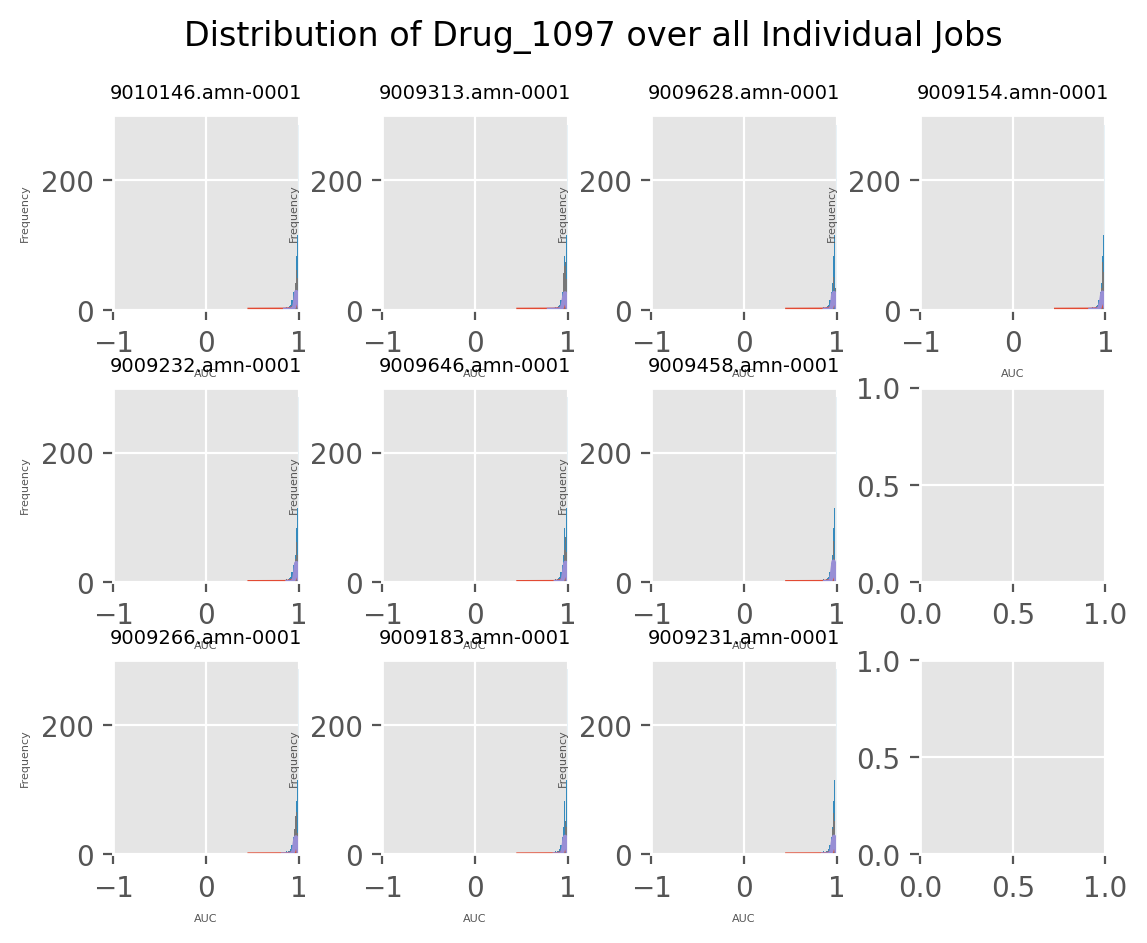

In [231]:
make_vs_multiplot("Drug_1097", path=path, wanted_jobs=os.listdir(path))

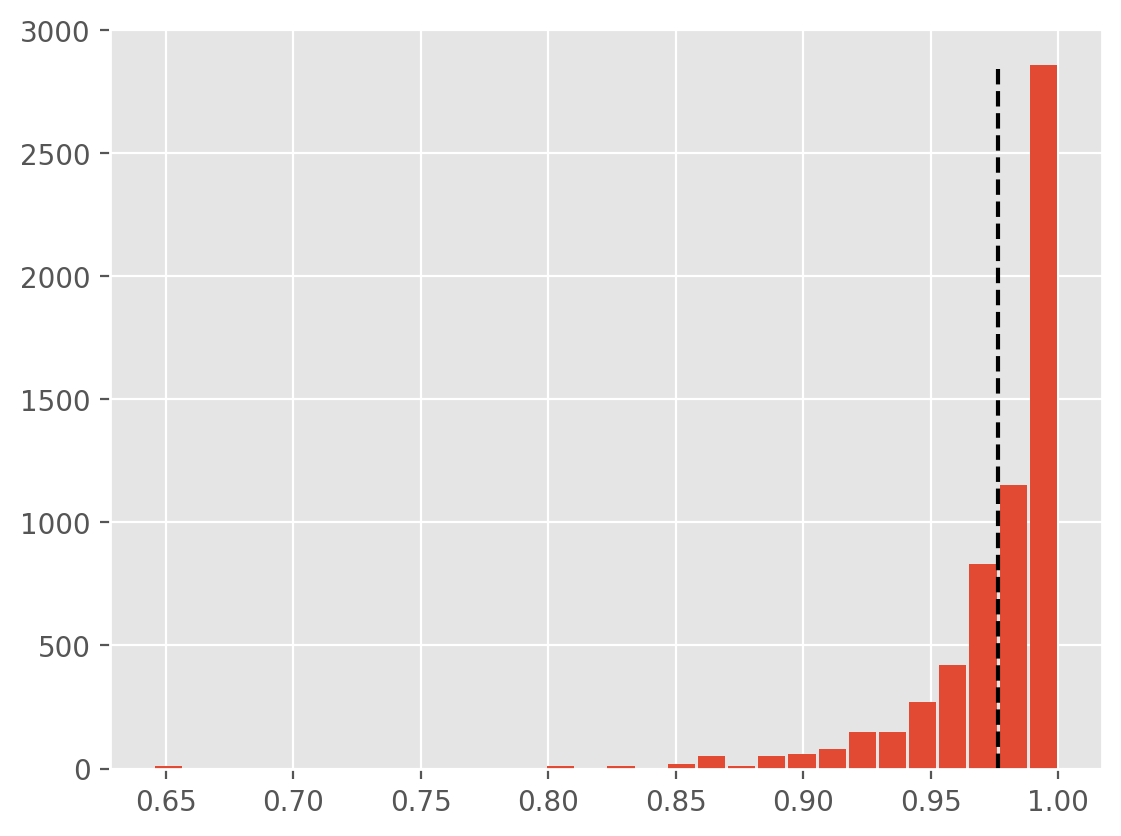

In [232]:
d_1078 = drug_dict["Drug_1097"]


fig, ax = plt.subplots()
confint = st.t.interval(confidence = 0.95, 
                        df = len(d_1078["AUC"])-1, 
                        loc = np.mean(d_1078["AUC"]), 
                        scale = st.sem(d_1078["AUC"]) )

heights, bins, patches = ax.hist(d_1078["AUC"], bins=30, rwidth=0.9)
ax.vlines(x = np.mean(d_1078["AUC"]), 
          ymin = 0, 
          ymax=max(heights), 
          colors="black", 
          linestyles="dashed")

Text(0.5, 1.0, 'Distribution of Drug AUCError Variation')

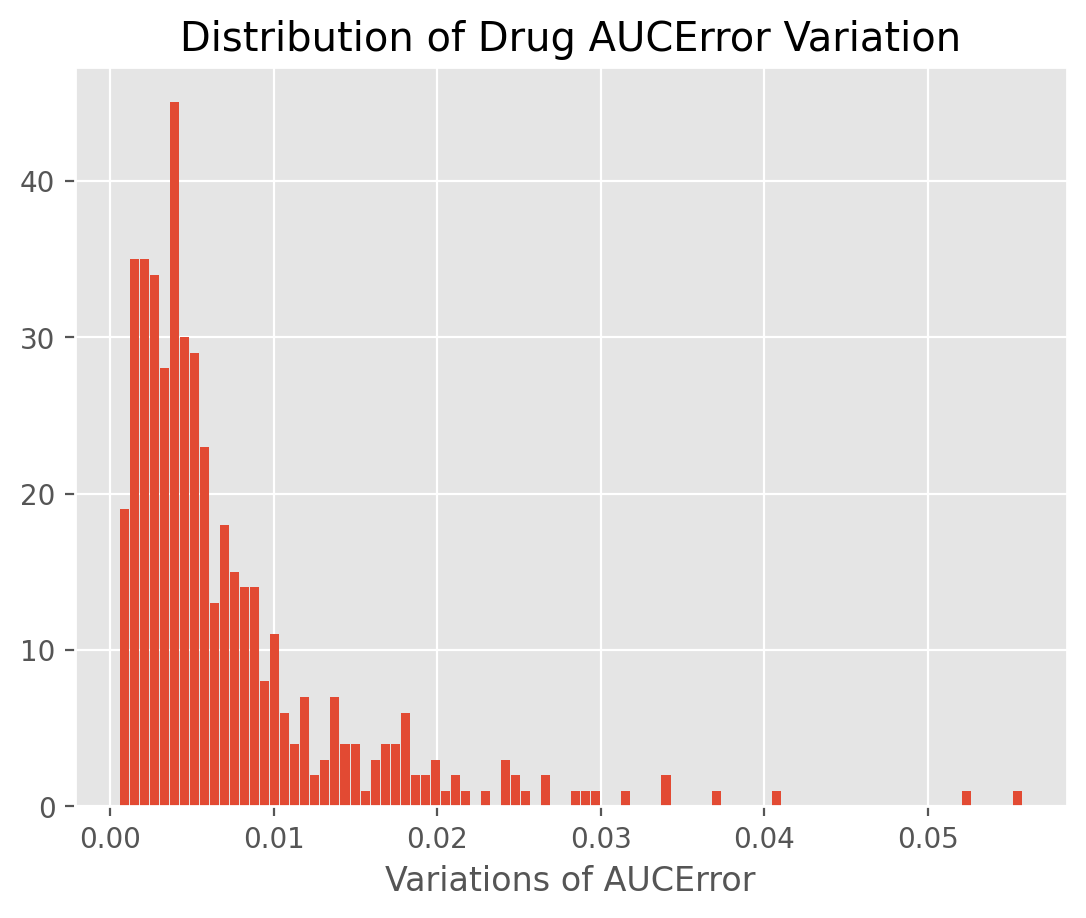

In [122]:
fig, ax1 = plt.subplots()
ax1.hist(x= all_drugs_df_rmse["var"], 
         density = False, 
         bins=90, 
         rwidth = 0.9)
ax1.set_xlabel(f"Variations of AUCError")
ax1.set_title("Distribution of Drug AUCError Variation")

Text(0.5, 1.0, 'Distribution of Drug RMSEs')

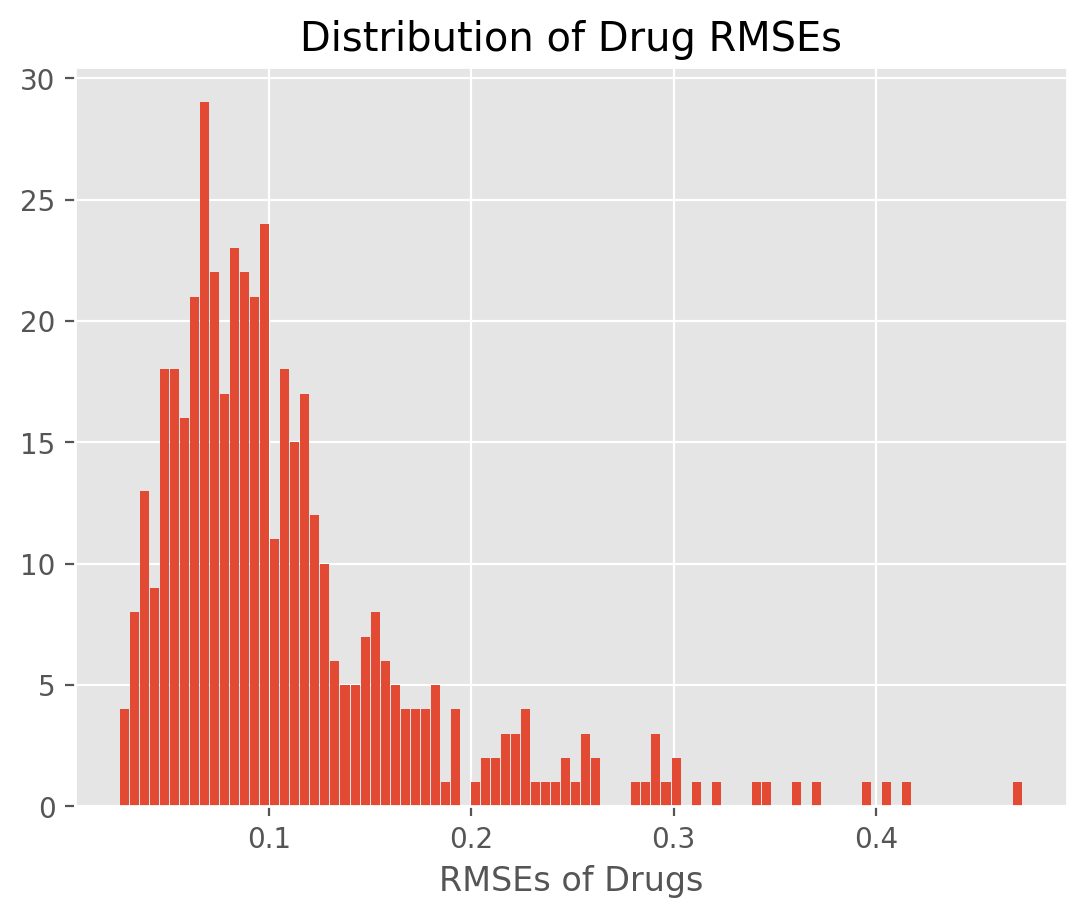

In [123]:
fig, ax1 = plt.subplots()
ax1.hist(x= all_drugs_df_rmse["RMSE"], 
         density = False, 
         bins=90, 
         rwidth = 0.9)
ax1.set_xlabel(f"RMSEs of Drugs")
ax1.set_title("Distribution of Drug RMSEs")

In [124]:
drugs_perf = {}

jobs = []

rmse_jobs = []
worst_drugs = []
rmse_jobs = []
all_locations = []

for job in os.listdir(path):
    j_path = os.path.join(path, job)
    
    rmses_curr = {}
    
    jobs.append(job)
    
    if job in os.listdir(path):
    
        for fold in os.listdir(j_path):
            
            fold_path = os.path.join(j_path, fold)
            
            if os.path.isdir(fold_path):
            
                inner_most = os.path.join(fold_path, job) 
                # print(f"###{fold}####")
                for num in os.listdir(inner_most):
                    num_path = os.path.join(inner_most, num)
                    tsv_file = os.path.join(num_path, "predicted.tsv")
                    df = pd.read_csv(tsv_file, sep="\t")
                    
                    # Getting folder locatio and which drug it is 
                    fold_num = num
                    drug = df["Drug1"][0]
                    
                    rmse = mean_squared_error(df["AUC"], df["PredictedAUC"], squared=False)
                    
                    # print(num, drug)
                    
                    key = (drug, fold_num)
                    rmses_curr[(key)] = rmse
                    # print(rmses_curr)
        worst_drug = max(rmses_curr, key = rmses_curr.get)      
        worst_drug_rmse = rmses_curr[worst_drug]
        print(worst_drug, worst_drug_rmse)
        
        worst_drugs.append(worst_drug[0])
        rmse_jobs.append(worst_drug_rmse)
        all_locations.append(worst_drug[1])
        
bad_drugs = pd.DataFrame({"Job":jobs, "Folder":all_locations, "worst_drug":worst_drugs, "RMSE":rmse_jobs})
bad_drugs.sort_values("RMSE", ascending=False)

# Getting the frequency of each drug in the worst drug array
drugs, counts = np.unique(worst_drugs, return_counts=True)

('Drug_1078', '129') 0.4386975469738552
('Drug_718', '230') 0.4413033379177498
('Drug_1078', '129') 0.478624711045758
('Drug_1078', '129') 0.516860636636217
('Drug_718', '230') 0.4832248748166603
('Drug_1078', '129') 0.4889331647869548
('Drug_1078', '129') 0.47439444254028945
('Drug_1078', '129') 0.49931217281385204
('Drug_1078', '129') 0.46936885592785693
('Drug_1078', '129') 0.4679823028004198


/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_41183/1669054811.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(drugs, rotation = 45)


Text(0.5, 0.98, 'Worst Performing Drugs Across All Jobs\n(Worst Drug for Each Job)')

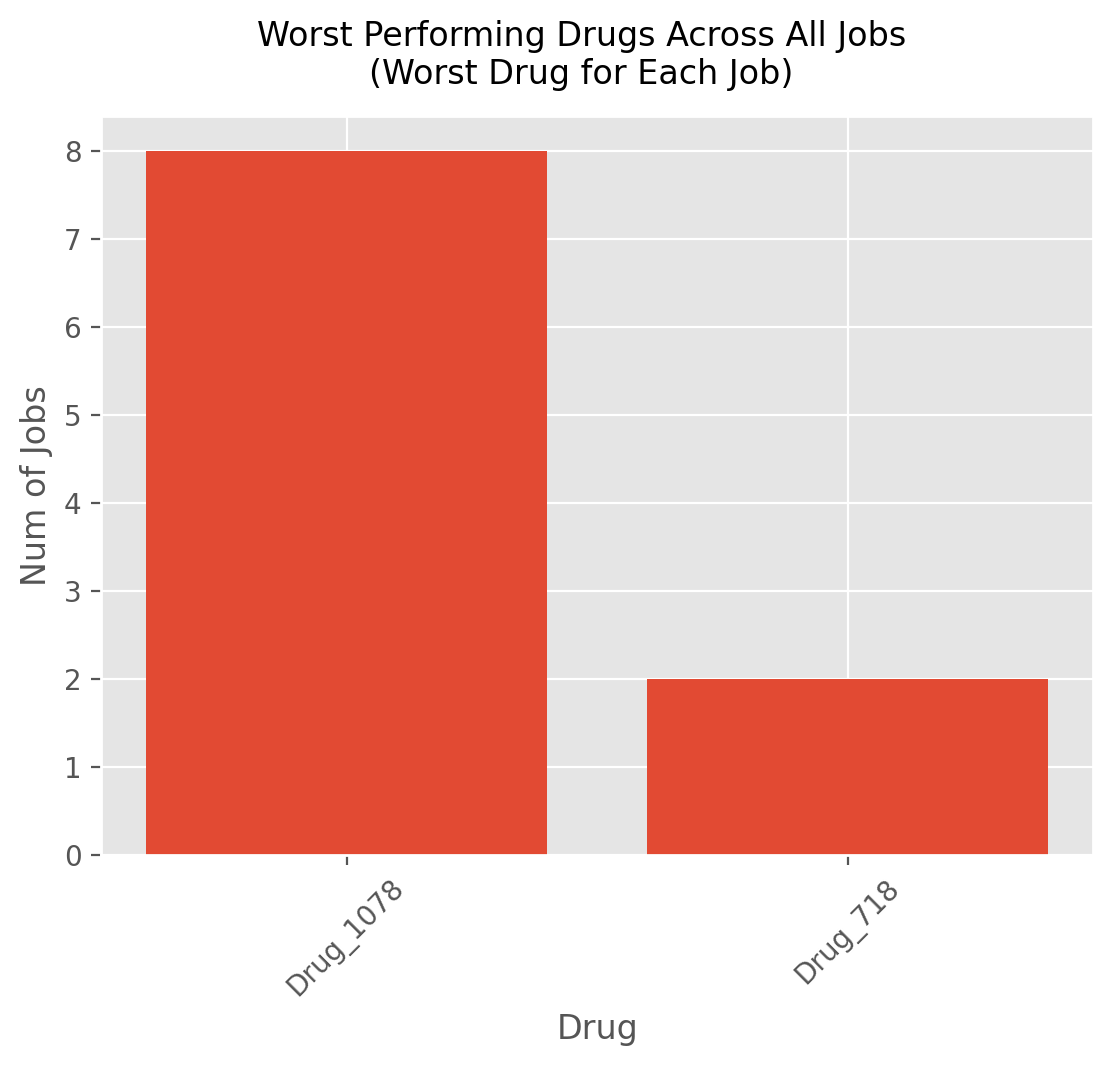

In [125]:
fig, ax = plt.subplots()

ax.bar(drugs, counts)

ax.set_xticklabels(drugs, rotation = 45)
ax.set_ylabel("Num of Jobs")
ax.set_xlabel("Drug")
fig.suptitle("Worst Performing Drugs Across All Jobs\n(Worst Drug for Each Job)")

## Drug 1078 Investigation --> High RMSE, low var

### Distributions

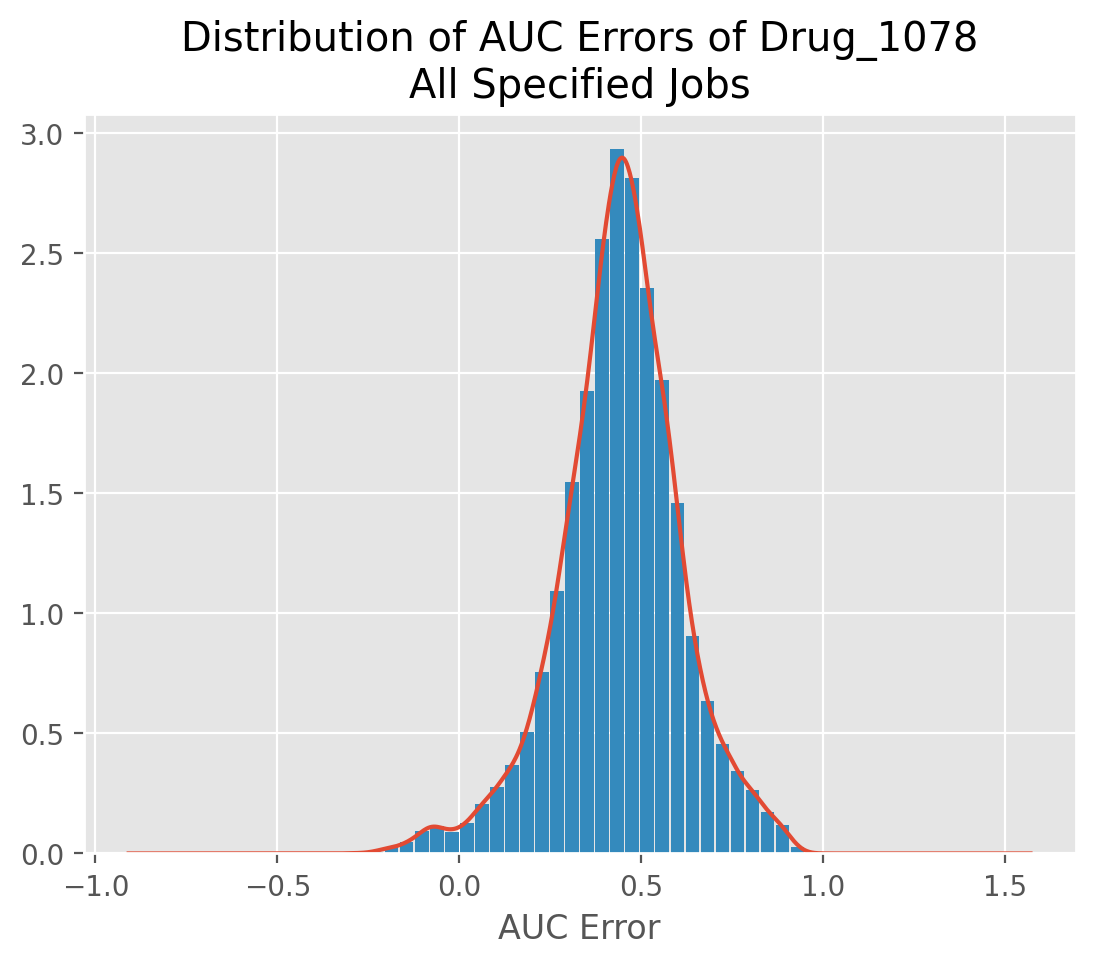

In [126]:
make_distrib_plot("Drug_1078", drug_dict)

Text(0.5, 1.0, 'Drug_1078 Actual AUC distrib vs Predicted AUC Distrib')

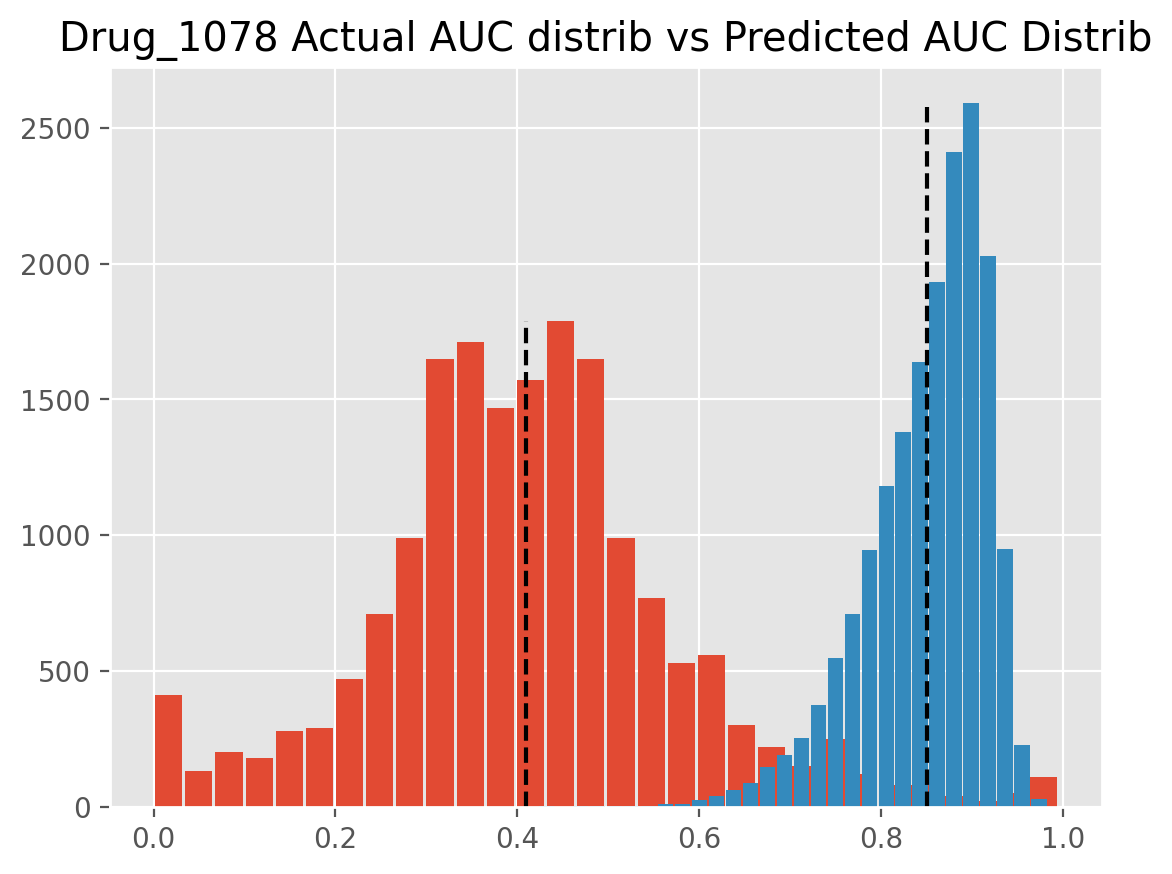

In [216]:
# for key in tqdm.tqdm(drug_dict.keys()):
#      dfs, j= get_all_drug_dfs(key, path=path, wanted_jobs=os.listdir(path))
#      print(f"Drug: {key}---dfs: {len(dfs)}")



d_1078 = drug_dict["Drug_1078"]


fig, ax = plt.subplots()
confint = st.t.interval(confidence = 0.95, 
                        df = len(d_1078["AUC"])-1, 
                        loc = np.mean(d_1078["AUC"]), 
                        scale = st.sem(d_1078["AUC"]) )

heights, bins, patches = ax.hist(d_1078["AUC"], bins=30, rwidth=0.9)
ax.vlines(x = np.mean(d_1078["AUC"]), 
          ymin = 0, 
          ymax=max(heights), 
          colors="black", 
          linestyles="dashed")


confint = st.t.interval(confidence = 0.95, 
                        df = len(d_1078["PredictedAUC"])-1, 
                        loc = np.mean(d_1078["PredictedAUC"]), 
                        scale = st.sem(d_1078["PredictedAUC"]) )

heights, bins, patches = ax.hist(d_1078["PredictedAUC"], bins=30, rwidth=0.9)
ax.vlines(x = np.mean(d_1078["PredictedAUC"]), 
          ymin = 0, 
          ymax=max(heights), 
          colors="black", 
          linestyles="dashed")

ax.set_title(f"Drug_1078 Actual AUC distrib vs Predicted AUC Distrib")
# ax.set_ylabel("Bootstrap Sampes")
# ax.set_xlabel("AUC Error")
# ax.text(x = min(d_1078["AUC"]), y = 12000, s = confint, size = 8)
# ax.fill_betweenx([0, heights.max()],confint[0], confint[1], alpha = 0.1, color = "g")


TOTAL: 10-----((3.0, 4.0))
Job 9010146.amn-0001: Ttest_indResult(statistic=-96.42085422810284, pvalue=0.0)
Job 9009232.amn-0001: Ttest_indResult(statistic=-88.93062093160027, pvalue=0.0)
Job 9009266.amn-0001: Ttest_indResult(statistic=-107.93751822384861, pvalue=0.0)
Job 9009313.amn-0001: Ttest_indResult(statistic=-121.97648802709594, pvalue=0.0)
Job 9009646.amn-0001: Ttest_indResult(statistic=-104.66403900464708, pvalue=0.0)
Job 9009183.amn-0001: Ttest_indResult(statistic=-112.79502705129221, pvalue=0.0)
Job 9009628.amn-0001: Ttest_indResult(statistic=-104.91841634729046, pvalue=0.0)
Job 9009458.amn-0001: Ttest_indResult(statistic=-114.60409095699487, pvalue=0.0)
Job 9009231.amn-0001: Ttest_indResult(statistic=-103.9312769397635, pvalue=0.0)
Job 9009154.amn-0001: Ttest_indResult(statistic=-105.24767485944288, pvalue=0.0)


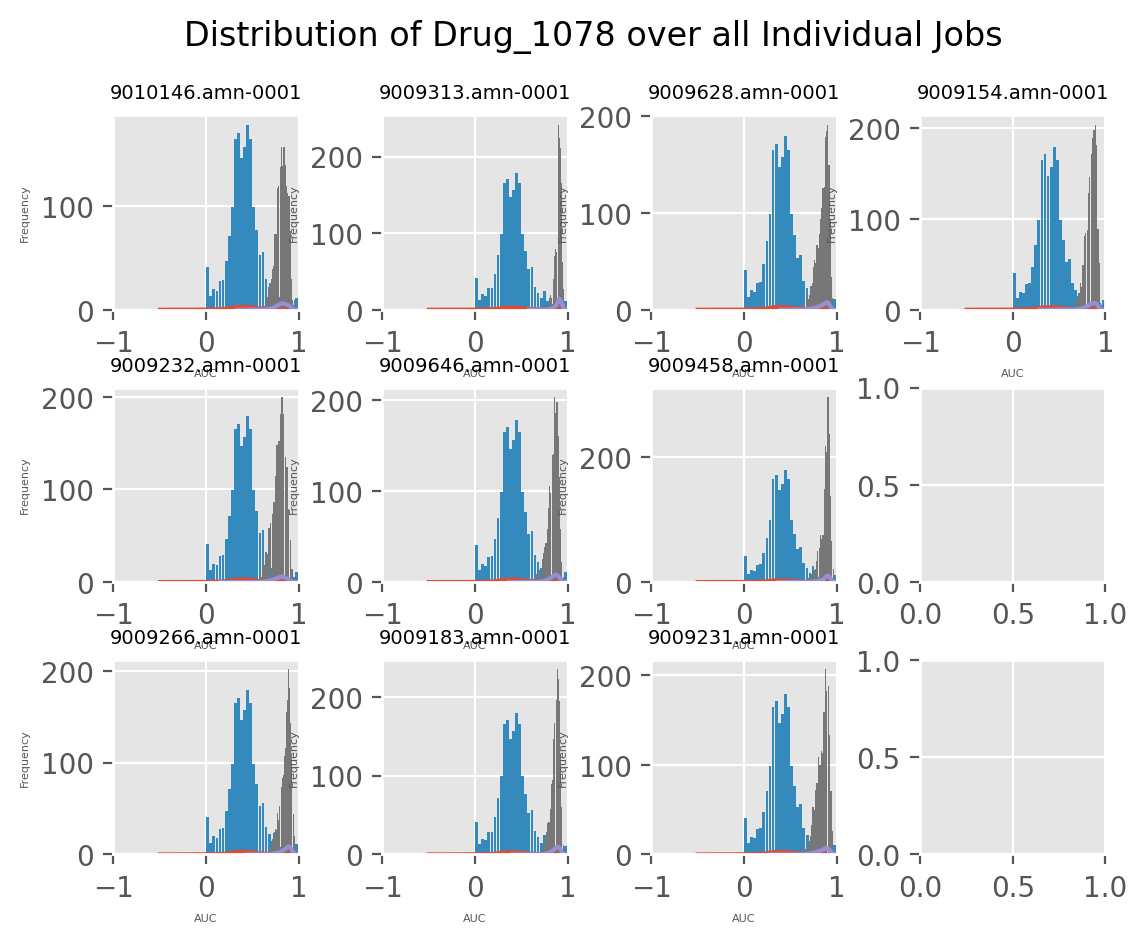

In [221]:
make_vs_multiplot("Drug_1078", path=path, wanted_jobs=os.listdir(path))

TOTAL: 10-----((3.0, 4.0))


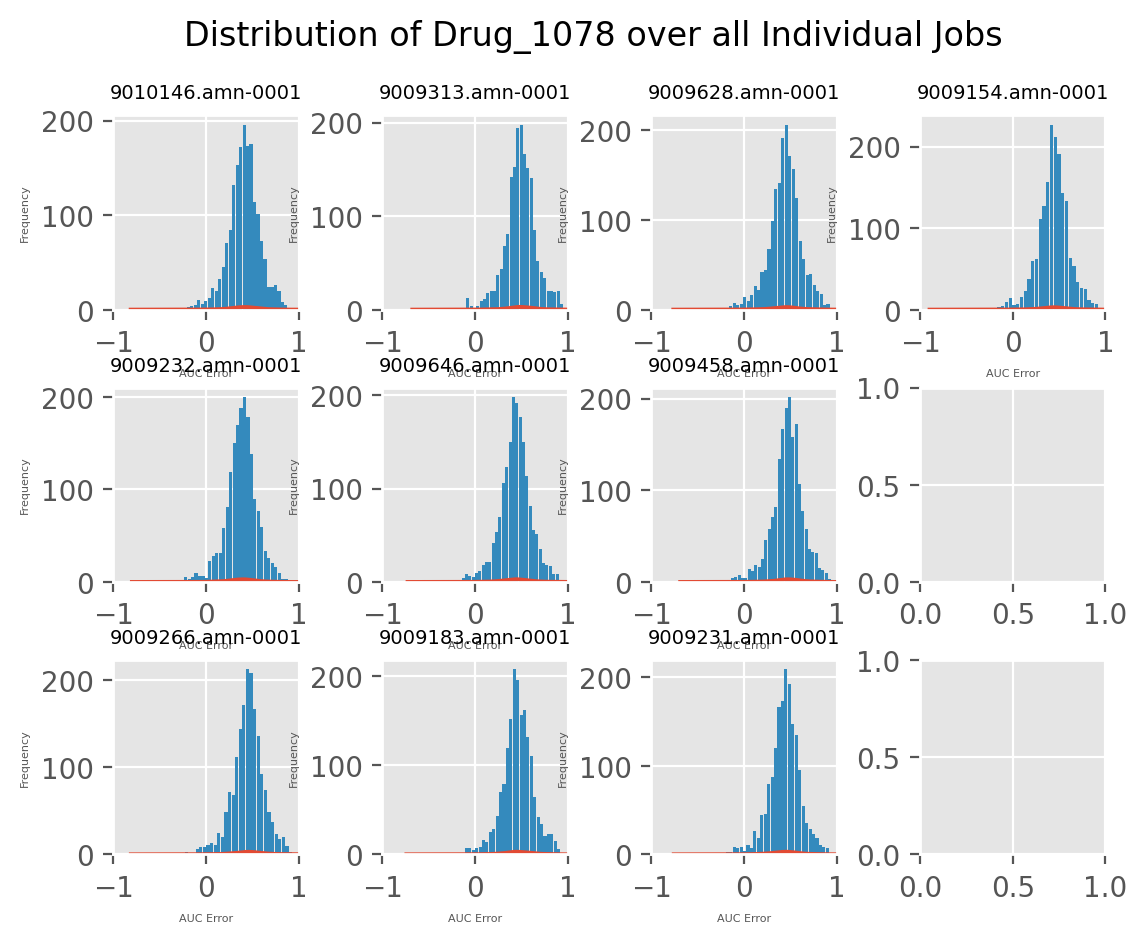

In [128]:
make_multiplot("Drug_1078", path=path, wanted_jobs=os.listdir(path))

### Bootstrapping

In [129]:
boot_1078 = boostraped_rmse(drug_dict["Drug_1078"], 100000)

100%|██████████| 100000/100000 [00:48<00:00, 2055.75it/s]


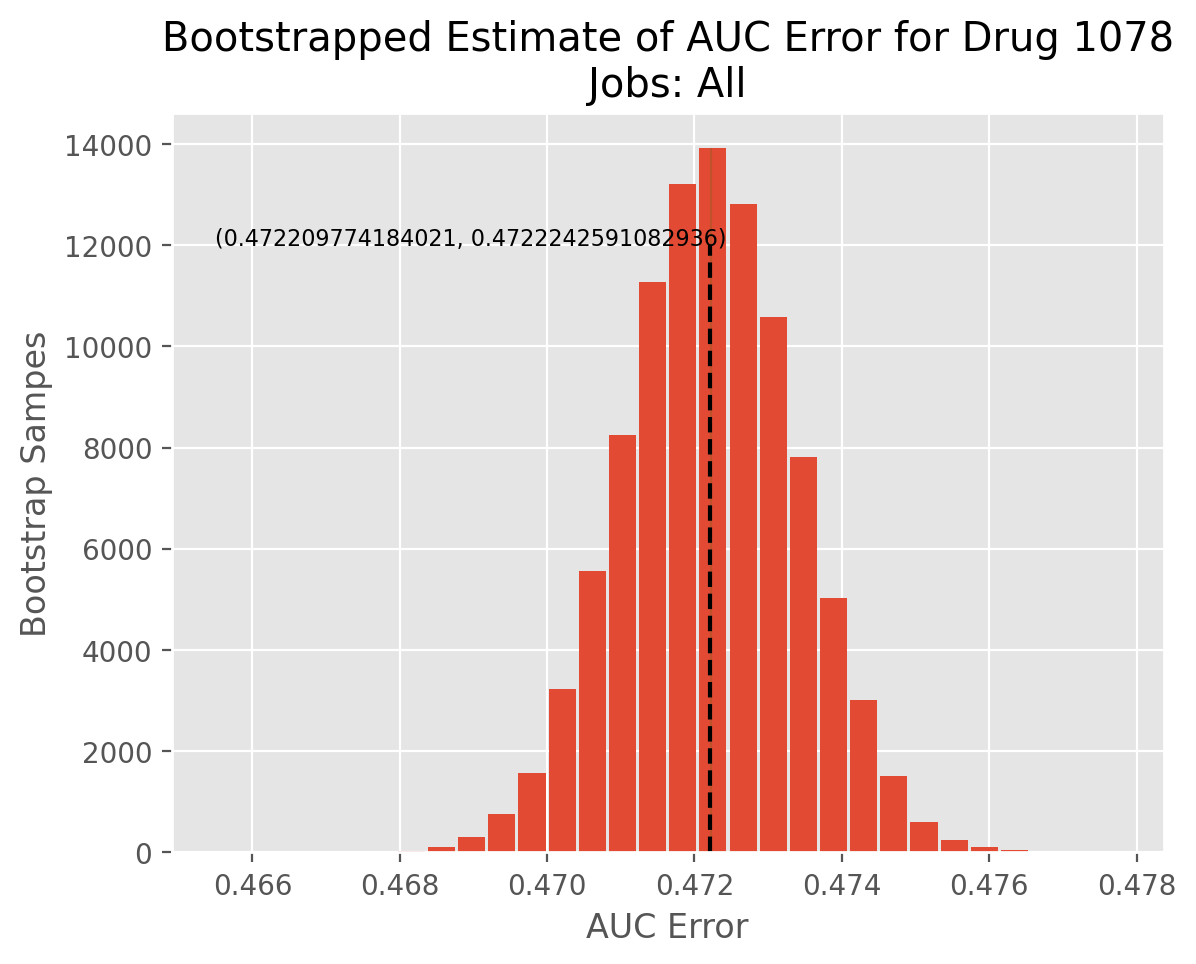

In [130]:
fig, ax = plt.subplots()
confint = st.t.interval(confidence = 0.95, 
                        df = len(boot_1078)-1, 
                        loc = np.mean(boot_1078), 
                        scale = st.sem(boot_1078) )

heights, bins, patches = ax.hist(boot_1078, bins=30, rwidth=0.9)
ax.vlines(x = np.mean(boot_1078), 
          ymin = 0, 
          ymax=12000, 
          colors="black", 
          linestyles="dashed")

ax.set_title(f"Bootstrapped Estimate of AUC Error for Drug 1078\nJobs: All")
ax.set_ylabel("Bootstrap Sampes")
ax.set_xlabel("AUC Error")
ax.text(x = min(boot_1078), y = 12000, s = confint, size = 8)
ax.fill_betweenx([0, heights.max()],confint[0], confint[1], alpha = 0.1, color = "g")

### Tukey HSD Testing against Drugs in start_288

In [131]:
dfs_ALL = []

for val in drug_dict.values():
    dfs_ALL.append(val)
    
df = pd.concat(dfs_ALL)

In [132]:
df

,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.9901,ACH-000002,Drug_618,0.6198,-0.370300
1,0.9577,ACH-000005,Drug_618,0.5463,-0.411400
2,0.9923,ACH-000008,Drug_618,0.6922,-0.300100
3,0.9221,ACH-000009,Drug_618,0.6542,-0.267900
4,0.9638,ACH-000014,Drug_618,0.6835,-0.280300
...,...,...,...,...,...
643,0.8888,ACH-001075,Drug_752,0.9015,0.012720
644,0.8913,ACH-001239,Drug_752,0.9007,0.009370
645,0.8497,ACH-001306,Drug_752,0.9347,0.084970
646,0.9356,ACH-001307,Drug_752,0.9287,-0.006936


In [133]:
csv = pairwise_tukeyhsd(df["AUCError"], df["Drug1"], alpha = 0.05).summary().as_csv()
turkey_df = pd.read_csv(StringIO(csv), skiprows = 1)
turkey_df["  group1 "] = turkey_df["  group1 "].str.strip()
turkey_df["  group2 "] = turkey_df["  group2 "].str.strip()

In [134]:
print(turkey_df[turkey_df["  group1 "] == "Drug_1078"].to_string())
# print(turkey_df["  group1 "])
# print(turkey_df.to_string())


         group1     group2   meandiff  p-adj    lower    upper   reject
10644  Drug_1078  Drug_1082   -0.2731     0.0  -0.2793  -0.2669  True  
10645  Drug_1078  Drug_1085   -0.4992     0.0  -0.5060  -0.4924  True  
10646  Drug_1078  Drug_1086   -0.5733     0.0  -0.5809  -0.5658  True  
10647  Drug_1078  Drug_1096   -0.3842     0.0  -0.3908  -0.3775  True  
10648  Drug_1078  Drug_1097   -0.4468     0.0  -0.4533  -0.4403  True  
10649  Drug_1078  Drug_1098   -0.4561     0.0  -0.4667  -0.4455  True  
10650  Drug_1078  Drug_1099   -0.4453     0.0  -0.4558  -0.4348  True  
10651  Drug_1078  Drug_1100   -0.4413     0.0  -0.4475  -0.4350  True  
10652  Drug_1078  Drug_1101   -0.4285     0.0  -0.4392  -0.4179  True  
10653  Drug_1078  Drug_1110   -0.4227     0.0  -0.4273  -0.4182  True  
10654  Drug_1078  Drug_1116   -0.3935     0.0  -0.3987  -0.3884  True  
10655  Drug_1078  Drug_1117   -0.2685     0.0  -0.2747  -0.2622  True  
10656  Drug_1078  Drug_1122   -0.3017     0.0  -0.3086  -0.2947 

### Tukey HSD Testing against ALL Drugs

In [135]:
jobs_75 = ['8997987.amn-0001', '8999189.amn-0001', '8998722.amn-0001','8999163.amn-0001']
dict_75 =get_data_ALL(path=path1, wanted_jobs=jobs_75)


100%|██████████| 144/144 [00:00<00:00, 1372.99it/s]


In [136]:
dict_75["Drug_988"]

,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.2903,ACH-000001,Drug_988,0.3989,0.10860
1,0.2636,ACH-000002,Drug_988,0.3680,0.10440
2,0.2858,ACH-000002,Drug_988,0.3475,0.06174
3,0.2929,ACH-000002,Drug_988,0.3611,0.06815
4,0.3114,ACH-000002,Drug_988,0.3865,0.07509
...,...,...,...,...,...
1896,0.3578,ACH-001307,Drug_988,0.9416,0.58380
1897,0.4194,ACH-001307,Drug_988,0.8959,0.47650
1898,0.3146,ACH-001318,Drug_988,0.9335,0.61890
1899,0.6505,ACH-001318,Drug_988,0.9279,0.27740


In [137]:
dfs_ALL_75 = []

for val in dict_75.values():
    dfs_ALL_75.append(val)
    
df_75 = pd.concat(dfs_ALL_75)
df_75[df_75["Drug1"] == "Drug_988"]

,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.2903,ACH-000001,Drug_988,0.3989,0.10860
1,0.2636,ACH-000002,Drug_988,0.3680,0.10440
2,0.2858,ACH-000002,Drug_988,0.3475,0.06174
3,0.2929,ACH-000002,Drug_988,0.3611,0.06815
4,0.3114,ACH-000002,Drug_988,0.3865,0.07509
...,...,...,...,...,...
1896,0.3578,ACH-001307,Drug_988,0.9416,0.58380
1897,0.4194,ACH-001307,Drug_988,0.8959,0.47650
1898,0.3146,ACH-001318,Drug_988,0.9335,0.61890
1899,0.6505,ACH-001318,Drug_988,0.9279,0.27740


In [138]:
big_df = pd.concat([df, df_75])
big_df[big_df["Drug1"] == "Drug_988"]


,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.2903,ACH-000001,Drug_988,0.3989,0.10860
1,0.2636,ACH-000002,Drug_988,0.3680,0.10440
2,0.2858,ACH-000002,Drug_988,0.3475,0.06174
3,0.2929,ACH-000002,Drug_988,0.3611,0.06815
4,0.3114,ACH-000002,Drug_988,0.3865,0.07509
...,...,...,...,...,...
1896,0.3578,ACH-001307,Drug_988,0.9416,0.58380
1897,0.4194,ACH-001307,Drug_988,0.8959,0.47650
1898,0.3146,ACH-001318,Drug_988,0.9335,0.61890
1899,0.6505,ACH-001318,Drug_988,0.9279,0.27740


In [139]:
aucdf = (big_df
    .groupby("Drug1")
    .agg({
        "AUCError":"mean"
    })
    .reset_index()
    .sort_values("AUCError", key=np.abs, ascending=False)
    
)

aucdf

,Drug1,AUCError
29,Drug_1078,0.441117
599,Drug_988,0.397629
30,Drug_1079,0.393502
492,Drug_736,0.388223
73,Drug_118,0.361173
...,...,...
64,Drug_1151,0.000680
230,Drug_1539,0.000661
379,Drug_457,-0.000558
42,Drug_1100,-0.000174


(-0.47, 0.47)

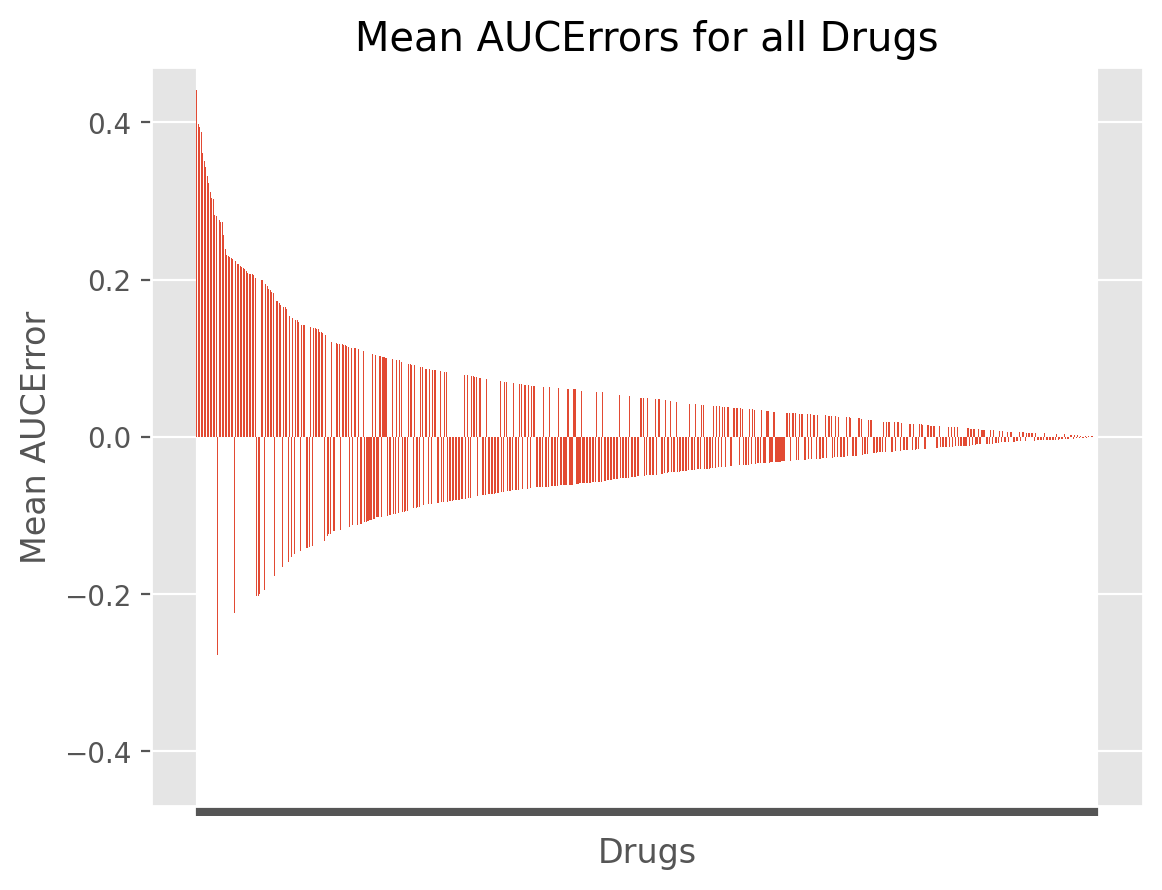

In [140]:
fig, ax = plt.subplots()

ax.bar(x = pd.Categorical(aucdf["Drug1"]), height=aucdf["AUCError"], width=0.7)
ax.set_xticklabels([])

ax.set_ylabel("Mean AUCError")
ax.set_xlabel("Drugs")
ax.set_title("Mean AUCErrors for all Drugs")
ax.set_ylim(-0.47, 0.47)

In [141]:
csv = pairwise_tukeyhsd(big_df["AUCError"], big_df["Drug1"], alpha = 0.05).summary().as_csv()
turkey_df = pd.read_csv(StringIO(csv), skiprows = 1)
turkey_df["  group1 "] = turkey_df["  group1 "].str.strip()
turkey_df["  group2 "] = turkey_df["  group2 "].str.strip()

In [142]:
print(turkey_df[turkey_df["  group1 "] == "Drug_1078"].to_string())
print(turkey_df[turkey_df["  group2 "] == "Drug_1078"].to_string())

         group1     group2   meandiff  p-adj    lower    upper   reject
16965  Drug_1078  Drug_1079   -0.0476     0.0  -0.0582  -0.0370  True  
16966  Drug_1078  Drug_1082   -0.2731     0.0  -0.2796  -0.2666  True  
16967  Drug_1078  Drug_1085   -0.4992     0.0  -0.5063  -0.4921  True  
16968  Drug_1078  Drug_1086   -0.5733     0.0  -0.5813  -0.5654  True  
16969  Drug_1078  Drug_1087   -0.4060     0.0  -0.4116  -0.4004  True  
16970  Drug_1078  Drug_1088   -0.4820     0.0  -0.4926  -0.4714  True  
16971  Drug_1078   Drug_109   -0.4634     0.0  -0.4708  -0.4560  True  
16972  Drug_1078  Drug_1094   -0.2570     0.0  -0.2672  -0.2468  True  
16973  Drug_1078  Drug_1096   -0.3842     0.0  -0.3912  -0.3772  True  
16974  Drug_1078  Drug_1097   -0.4468     0.0  -0.4536  -0.4400  True  
16975  Drug_1078  Drug_1098   -0.4561     0.0  -0.4672  -0.4450  True  
16976  Drug_1078  Drug_1099   -0.4453     0.0  -0.4563  -0.4343  True  
16977  Drug_1078  Drug_1100   -0.4413     0.0  -0.4479  -0.4347 

### Normality Testing

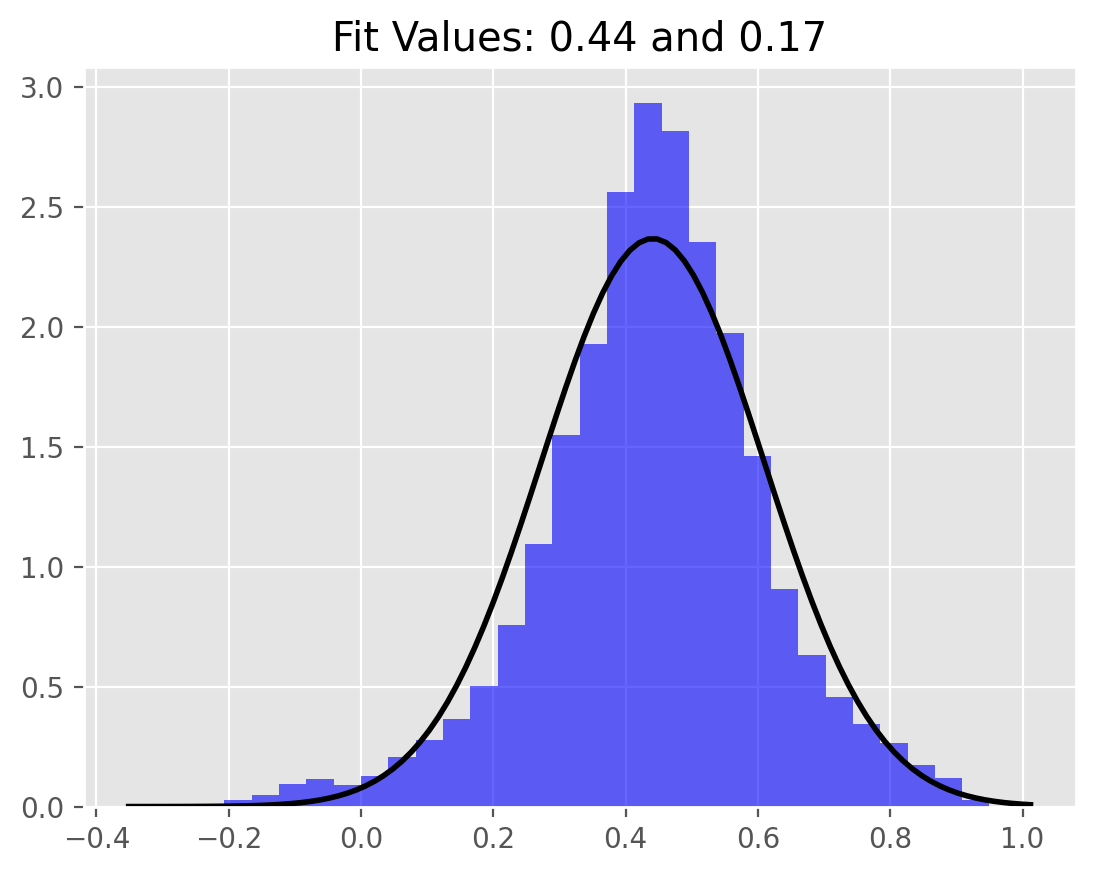

In [143]:
norm_hist(drug_dict["Drug_1078"]["AUCError"])

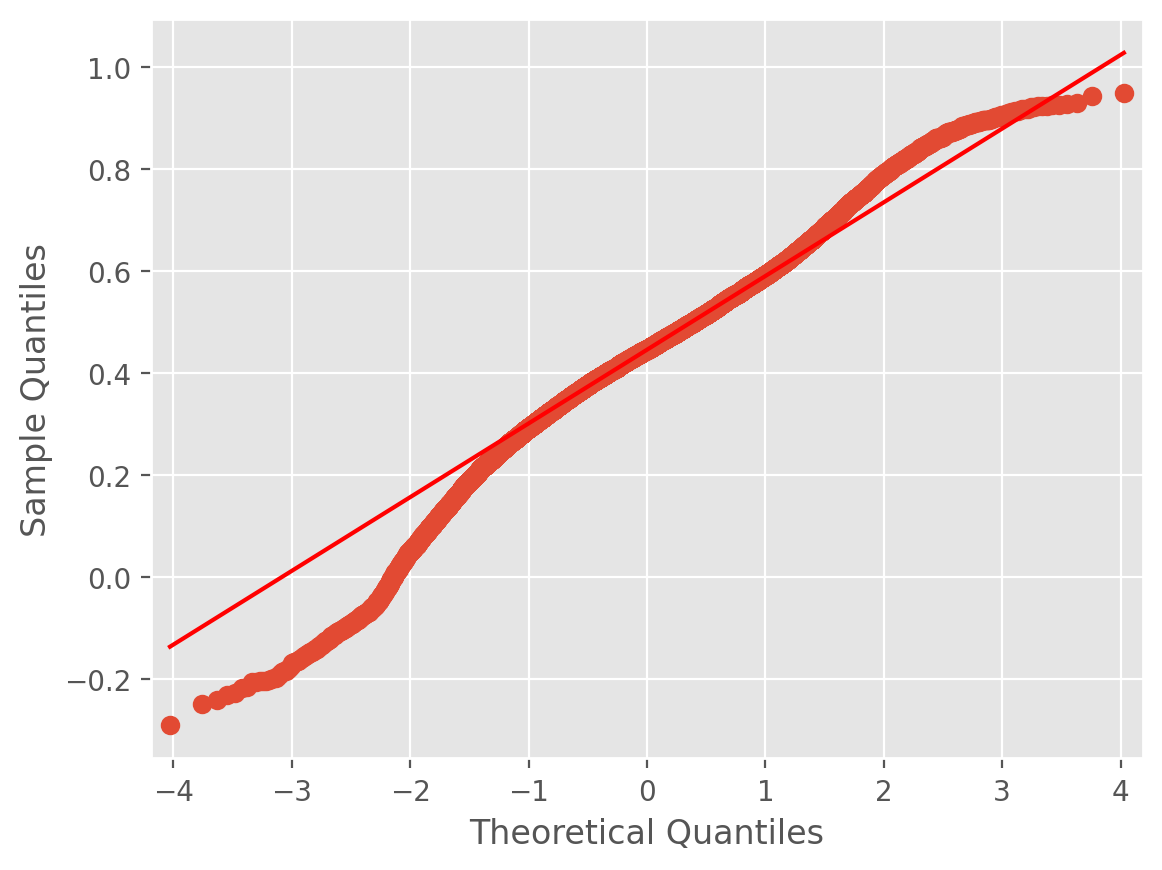

In [144]:
sm.qqplot(drug_dict["Drug_1078"]["AUCError"], line="q", a=1/2);

In [145]:
big_df["Sample"] = pd.Categorical(big_df["Sample"])
big_df["Drug1"] = pd.Categorical(big_df["Drug1"])


## Drug 718 -- High Variance, High Error

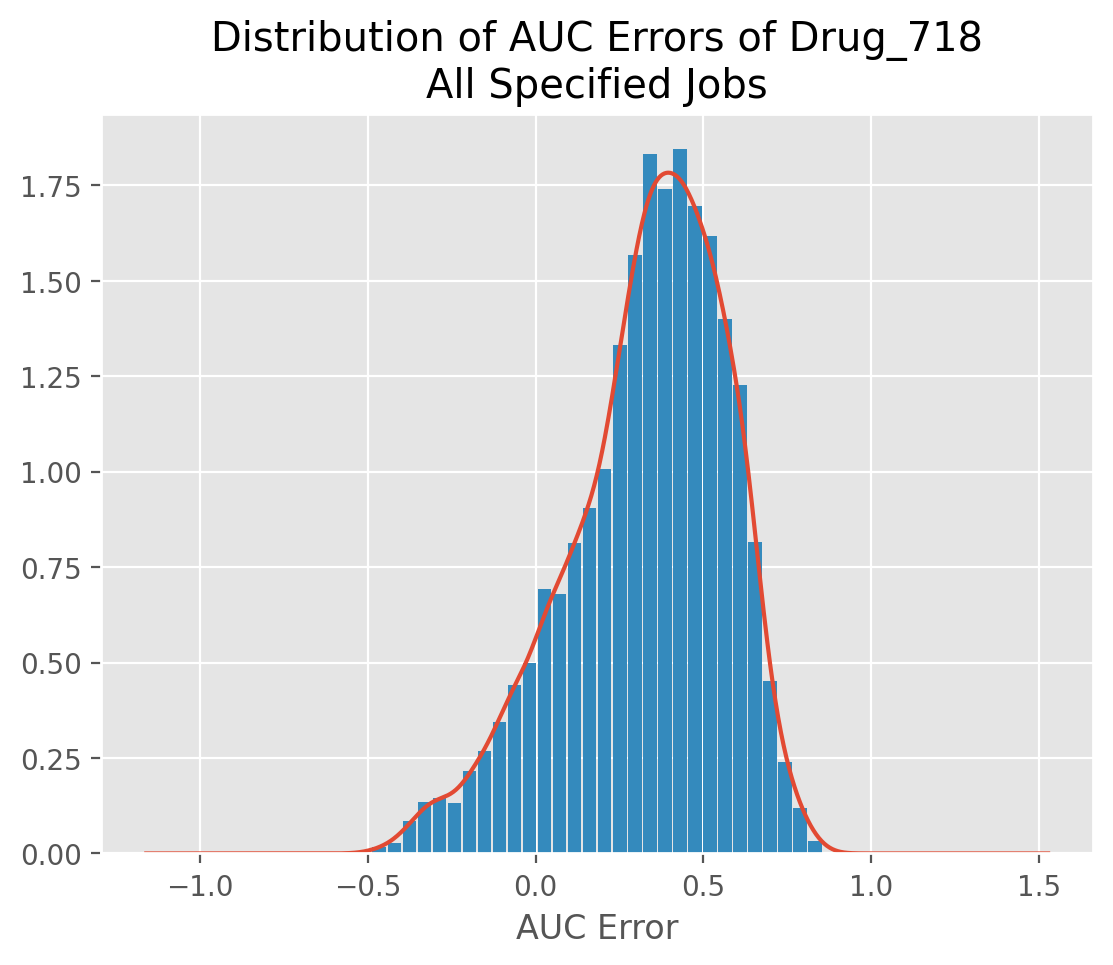

In [146]:
make_distrib_plot("Drug_718", drug_dict)

TOTAL: 10-----((3.0, 4.0))


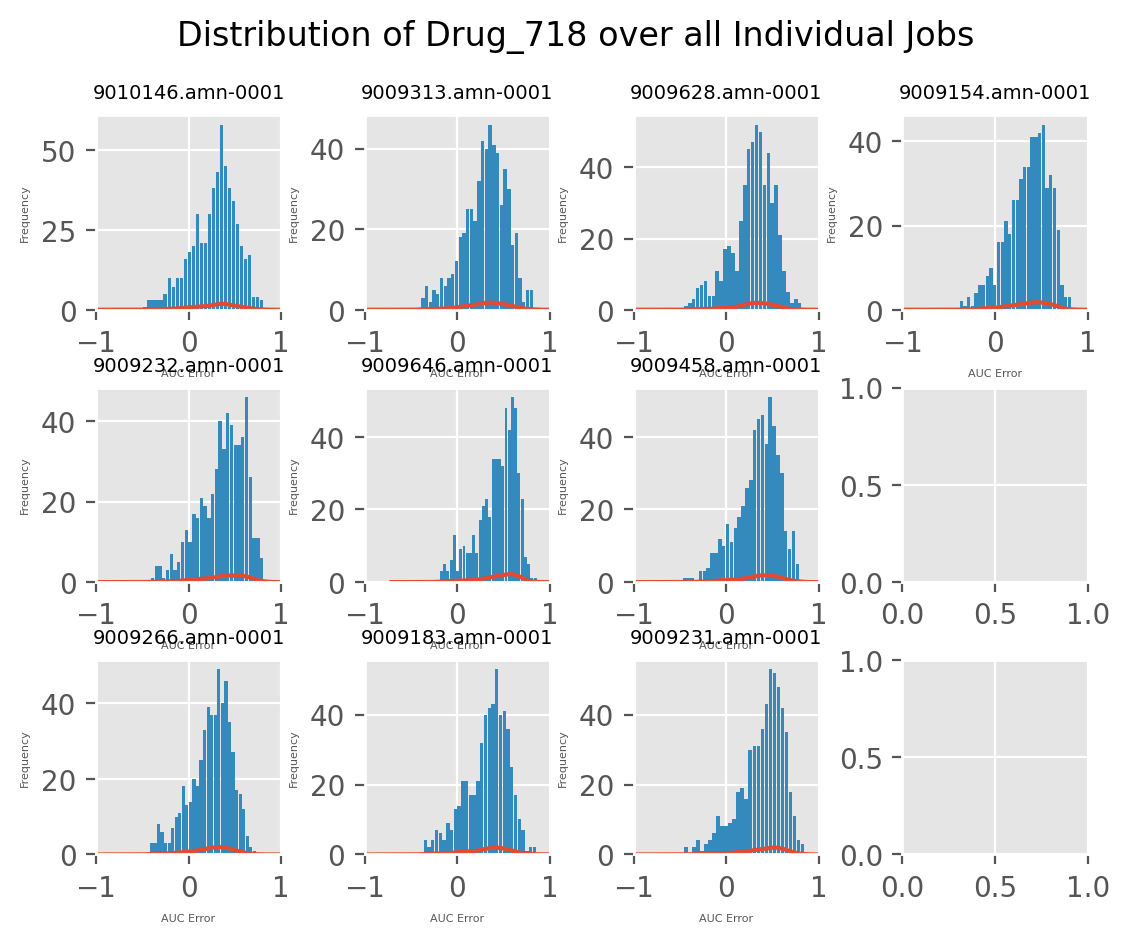

In [147]:
make_multiplot("Drug_718", path=path, wanted_jobs=os.listdir(path))

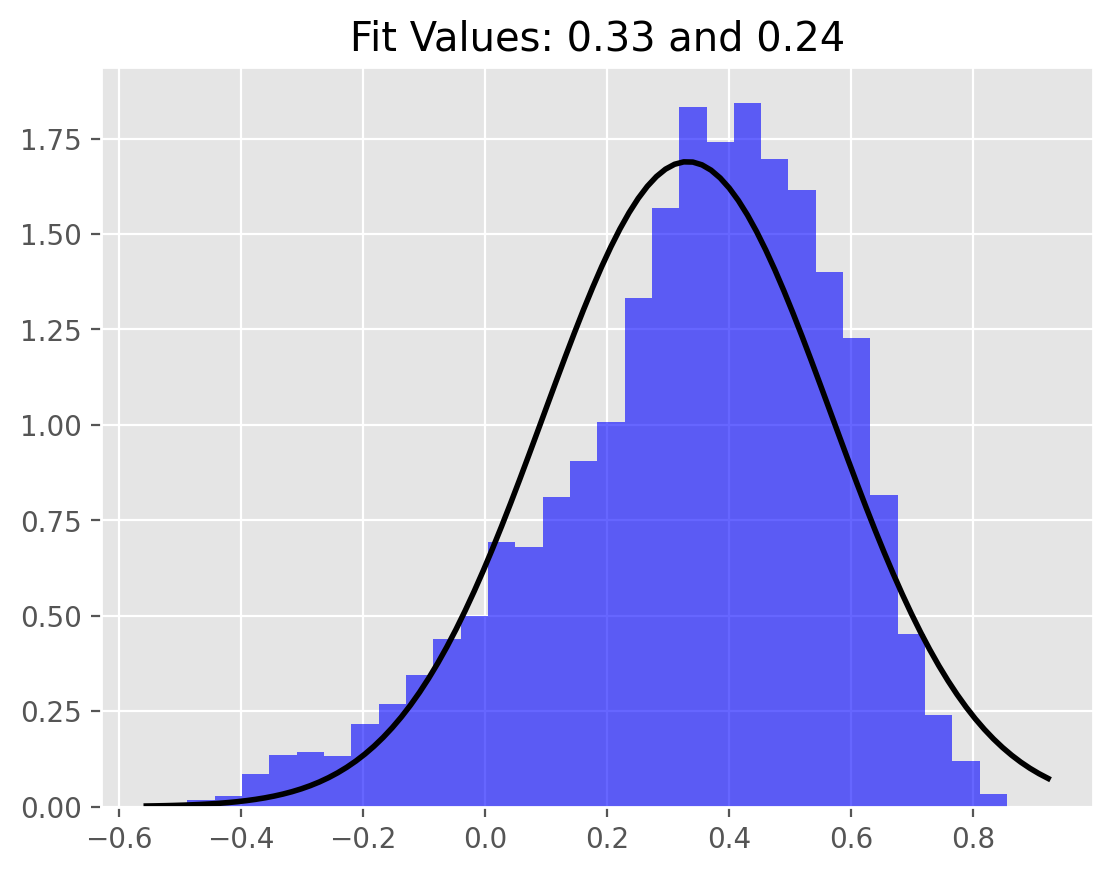

In [148]:
norm_hist(drug_dict["Drug_718"]["AUCError"])

In [149]:
# print(turkey_df[turkey_df["  group1 "] == "Drug_718"].to_string())
print(turkey_df[turkey_df["  group2 "] == "Drug_718"].to_string())

          group1    group2   meandiff  p-adj    lower    upper   reject
484       Drug_10  Drug_718    0.3393  0.0000   0.3304   0.3482  True  
1082    Drug_1005  Drug_718    0.2709  0.0000   0.2631   0.2787  True  
1679     Drug_101  Drug_718    0.3707  0.0000   0.3617   0.3798  True  
2275    Drug_1010  Drug_718    0.3325  0.0000   0.3242   0.3409  True  
2870    Drug_1012  Drug_718    0.3497  0.0000   0.3414   0.3580  True  
3464    Drug_1015  Drug_718    0.3518  0.0000   0.3402   0.3633  True  
4057    Drug_1016  Drug_718    0.2911  0.0000   0.2828   0.2995  True  
4649    Drug_1021  Drug_718    0.3374  0.0000   0.3291   0.3457  True  
5240    Drug_1022  Drug_718    0.4446  0.0000   0.4358   0.4533  True  
5830    Drug_1026  Drug_718    0.3343  0.0000   0.3221   0.3465  True  
6419    Drug_1028  Drug_718    0.3469  0.0000   0.3384   0.3553  True  
7007    Drug_1030  Drug_718    0.1038  0.0000   0.0956   0.1120  True  
7594    Drug_1032  Drug_718    0.1234  0.0000   0.1133   0.1335 

## Drug 984 --> High Variance, Low Error

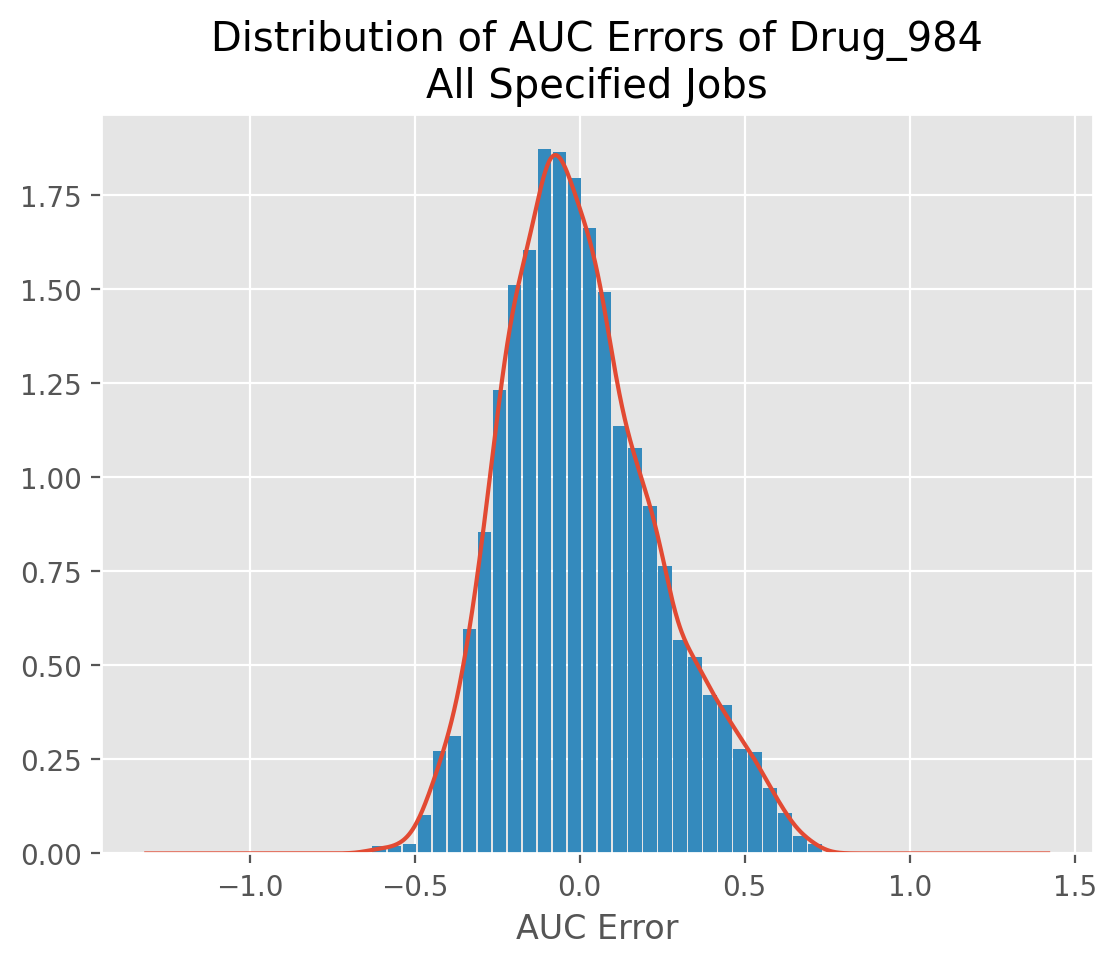

In [150]:
make_distrib_plot("Drug_984", drug_dict)

TOTAL: 10-----((3.0, 4.0))


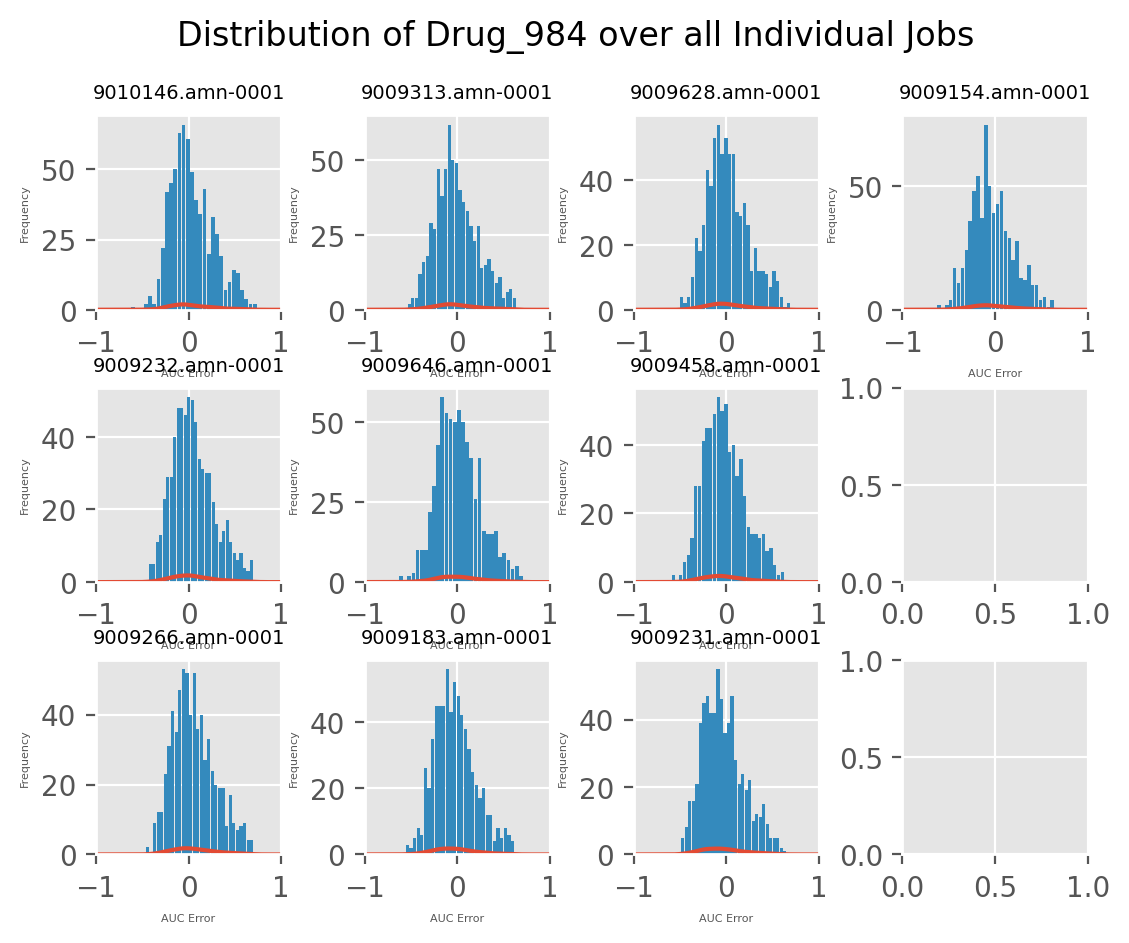

In [151]:
make_multiplot("Drug_984", path=path, wanted_jobs=os.listdir(path))

In [152]:
len(drug_dict["Drug_984"])

6930

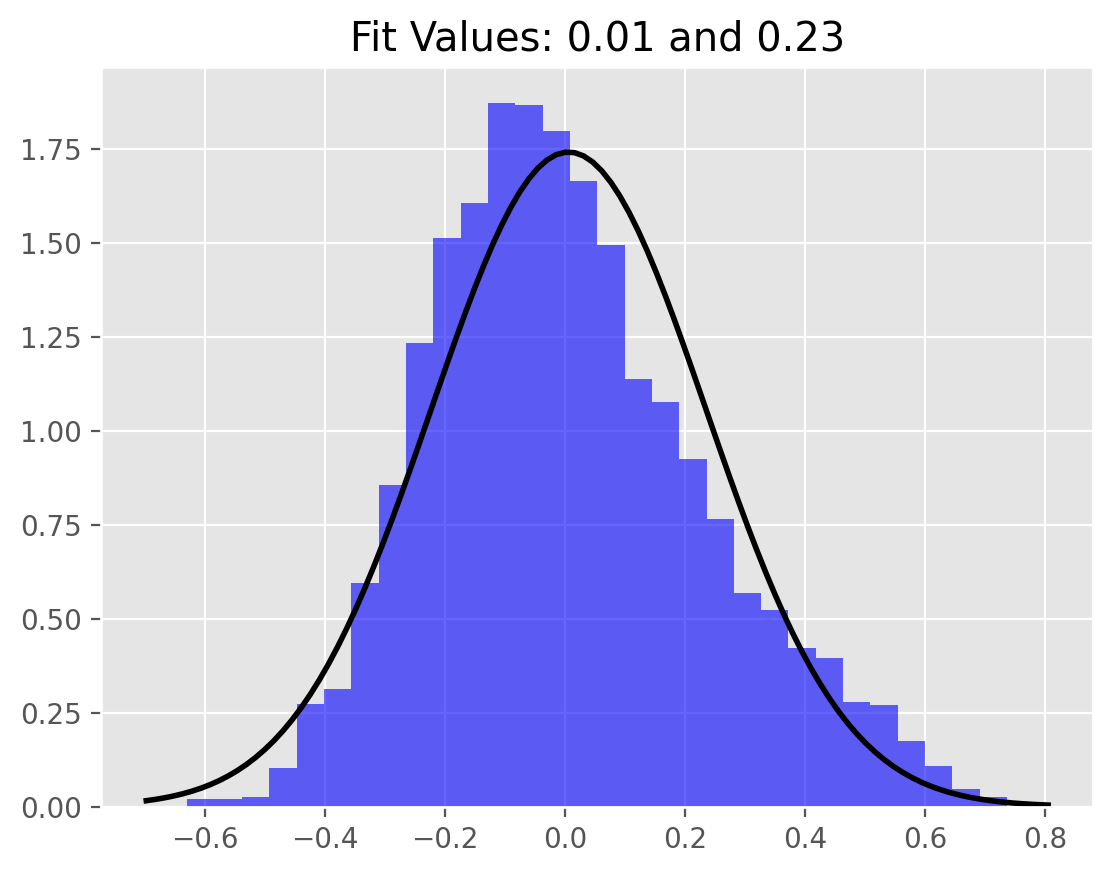

In [153]:
norm_hist(drug_dict["Drug_984"]["AUCError"])

In [154]:
boot_984 = boostraped_rmse(drug_dict["Drug_984"], 100000)

100%|██████████| 100000/100000 [00:19<00:00, 5083.08it/s]


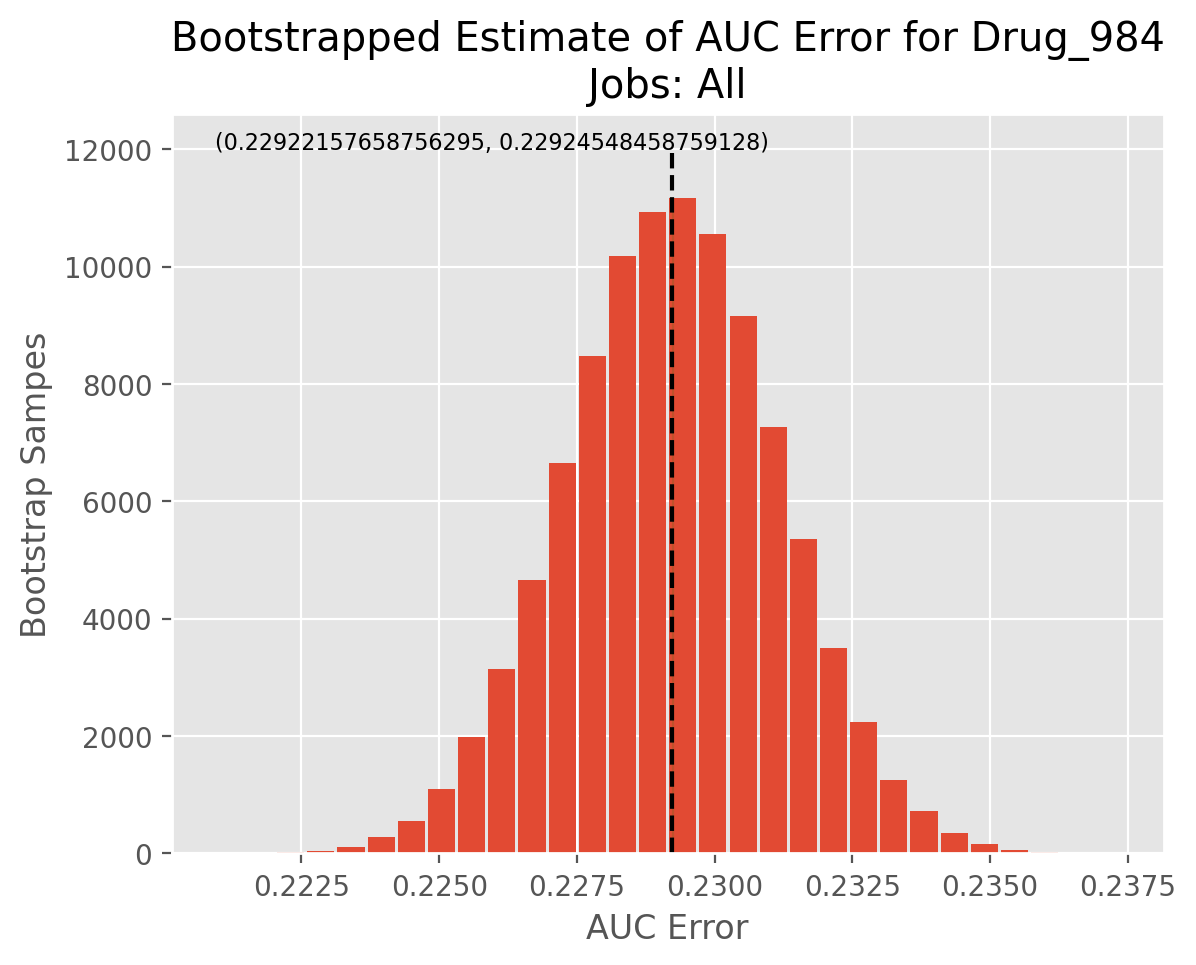

In [155]:
fig, ax = plt.subplots()
confint = st.t.interval(confidence = 0.95, 
                        df = len(boot_984)-1, 
                        loc = np.mean(boot_984), 
                        scale = st.sem(boot_984) )

heights, bins, patches = ax.hist(boot_984, bins=30, rwidth=0.9)
ax.vlines(x = np.mean(boot_984), 
          ymin = 0, 
          ymax=12000, 
          colors="black", 
          linestyles="dashed")

ax.set_title(f"Bootstrapped Estimate of AUC Error for Drug_984\nJobs: All")
ax.set_ylabel("Bootstrap Sampes")
ax.set_xlabel("AUC Error")
ax.text(x = min(boot_984), y = 12000, s = confint, size = 8)
ax.fill_betweenx([0, heights.max()],confint[0], confint[1], alpha = 0.1, color = "g")

In [156]:
# print(turkey_df[turkey_df["  group1 "] == "Drug_984"].to_string())
print(turkey_df[turkey_df["  group2 "] == "Drug_984"].to_string())

          group1    group2   meandiff  p-adj    lower    upper   reject
595       Drug_10  Drug_984    0.0131  0.0000   0.0046   0.0216  True  
1193    Drug_1005  Drug_984   -0.0553  0.0000  -0.0626  -0.0479  True  
1790     Drug_101  Drug_984    0.0446  0.0000   0.0359   0.0533  True  
2386    Drug_1010  Drug_984    0.0064  0.8081  -0.0015   0.0143  False 
2981    Drug_1012  Drug_984    0.0236  0.0000   0.0158   0.0314  True  
3575    Drug_1015  Drug_984    0.0256  0.0000   0.0144   0.0369  True  
4168    Drug_1016  Drug_984   -0.0350  0.0000  -0.0429  -0.0271  True  
4760    Drug_1021  Drug_984    0.0112  0.0000   0.0034   0.0191  True  
5351    Drug_1022  Drug_984    0.1184  0.0000   0.1101   0.1267  True  
5941    Drug_1026  Drug_984    0.0082  0.9996  -0.0038   0.0201  False 
6530    Drug_1028  Drug_984    0.0207  0.0000   0.0128   0.0287  True  
7118    Drug_1030  Drug_984   -0.2223  0.0000  -0.2301  -0.2146  True  
7705    Drug_1032  Drug_984   -0.2027  0.0000  -0.2125  -0.1930 

In [157]:
big_df[big_df["Drug1"] == "Drug_718"]

,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.3349,ACH-000001,Drug_718,0.8591,0.5242
1,0.3056,ACH-000002,Drug_718,0.8566,0.5510
2,0.2965,ACH-000004,Drug_718,0.6921,0.3956
3,0.3751,ACH-000006,Drug_718,0.7567,0.3816
4,0.6034,ACH-000007,Drug_718,0.7602,0.1568
...,...,...,...,...,...
553,0.3533,ACH-001190,Drug_718,0.8418,0.4885
554,0.3575,ACH-001306,Drug_718,0.7522,0.3947
555,0.1977,ACH-001307,Drug_718,0.7821,0.5844
556,0.2123,ACH-001307,Drug_718,0.7338,0.5215


## Variance Investigations

In [158]:
key_list = ["Drug", 
            "RMSE", 
            "var", 
            # "cv", 
            "n"]
drugs_stats = {key: [] for key in key_list}

drugs = big_df["Drug1"].unique()



for d in drugs: 
    drugs_stats["Drug"].append(d)
    curr_rmse = mean_squared_error(big_df[big_df["Drug1"] == d]["AUC"], big_df[big_df["Drug1"] == d]["PredictedAUC"], squared=False)
    curr_var = np.var(big_df[big_df["Drug1"] == d]["AUCError"])
    # curr_cv =  (np.std(value["AUCError"]) / np.mean(value["AUCError"])) * 100
    # drugs_rmse["cv"].append(curr_cv)
    drugs_stats["RMSE"].append(curr_rmse)
    drugs_stats["var"].append(curr_var)
    drugs_stats["n"].append(len(big_df[big_df["Drug1"] == d]))
    
drug_stats = pd.DataFrame(drugs_stats)

In [159]:
drug_stats.sort_values("var", ascending=False).head(50)

,Drug,RMSE,var,n
461,Drug_988,0.476854,0.069281,7604
591,Drug_1218,0.387117,0.057366,3303
131,Drug_718,0.407259,0.055751,5580
163,Drug_984,0.229245,0.052521,6930
480,Drug_1079,0.442923,0.041337,2124
422,Drug_118,0.413904,0.040871,6910
554,Drug_736,0.433573,0.037269,1647
150,Drug_428,0.292137,0.036834,5660
467,Drug_1062,0.286123,0.036305,2308
538,Drug_449,0.204842,0.034897,1815


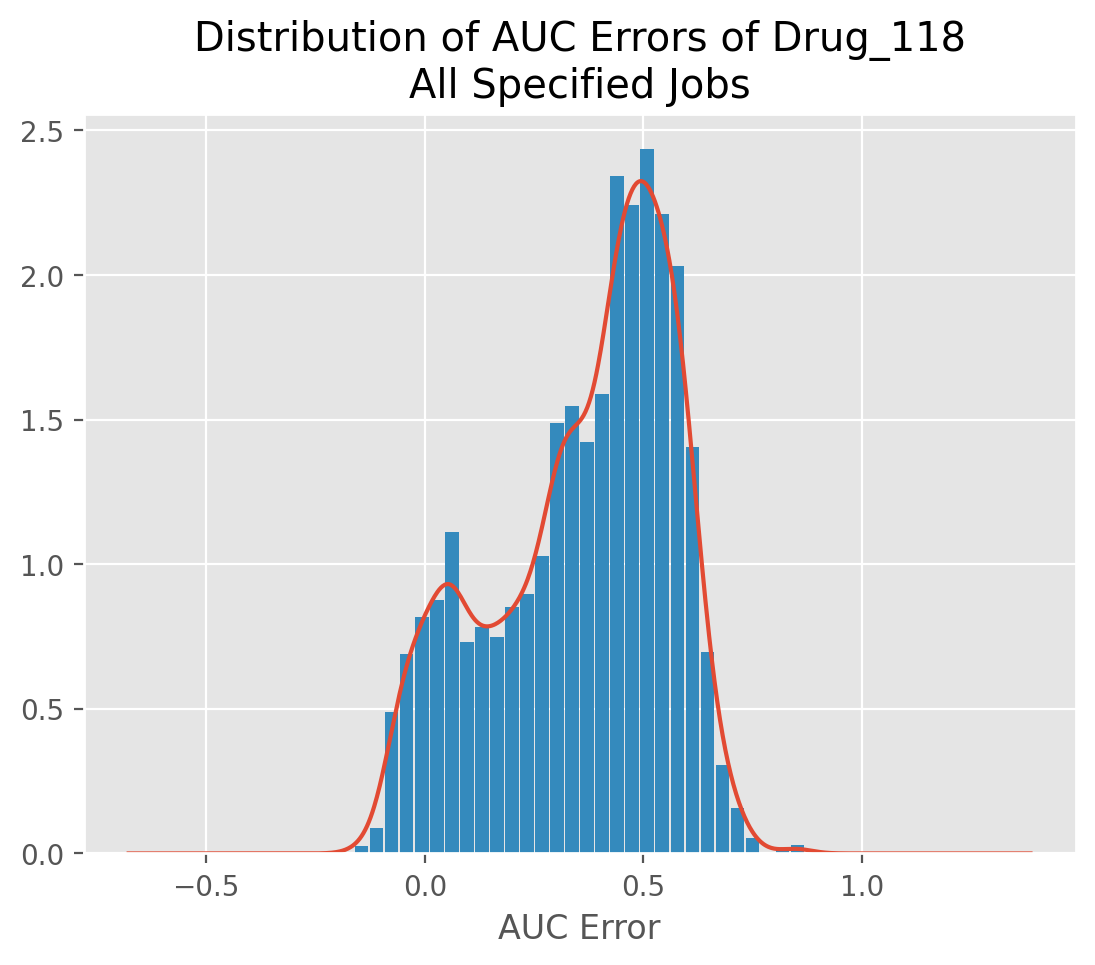

In [160]:
make_distrib_plot("Drug_118", drug_dict)

TOTAL: 10-----((3.0, 4.0))


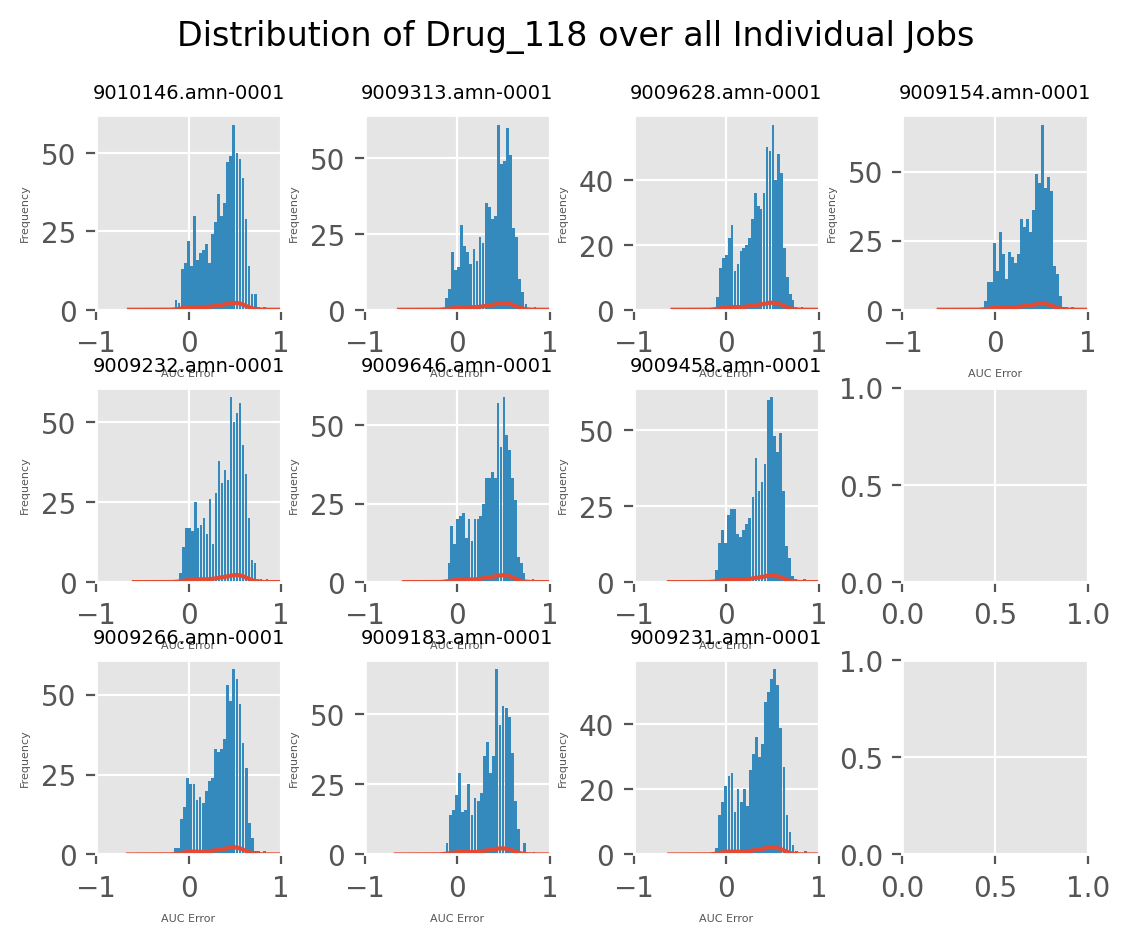

In [161]:
make_multiplot("Drug_118", path=path, wanted_jobs=os.listdir(path))

In [162]:
(big_df
    .groupby('Drug1')
    .AUCError
    .describe()
    # .tolist()
    # .head(50)
    # .reset_index()
    .sort_values("mean", ascending=False)
    .head(50)
 )

,count,mean,std,min,25%,50%,75%,max
Drug1,,,,,,,,
Drug_1078,17770.0,0.441117,0.168555,-0.28900,0.348600,0.44630,0.543475,0.9501
Drug_988,7604.0,0.397629,0.263231,-0.61350,0.140600,0.50300,0.591625,0.9032
Drug_1079,2124.0,0.393502,0.203363,-0.07066,0.238750,0.39920,0.549225,0.9021
Drug_736,1647.0,0.388223,0.193110,-0.01180,0.232950,0.36850,0.535050,0.9253
Drug_118,6910.0,0.361173,0.202180,-0.16140,0.219150,0.41135,0.518700,0.8694
Drug_1305,5760.0,0.350887,0.178017,-0.15040,0.237775,0.37620,0.482600,0.8164
Drug_1186,6930.0,0.342559,0.116601,-0.31160,0.274525,0.35280,0.424175,0.7358
Drug_718,5580.0,0.331826,0.236138,-0.48820,0.192725,0.36370,0.506500,0.8556
Drug_156,4914.0,0.323062,0.183825,-0.10350,0.172600,0.31120,0.465675,0.7757


In [201]:
d_1078, _ = get_all_drug_dfs("Drug_1078", path=path, wanted_jobs=os.listdir(path))

In [202]:
rmses_1078 = []
for d in d_1078:
    print(d)
    print(d["AUC"])
    rmse_curr = mean_squared_error(d["AUC"], d["PredictedAUC"], squared=False)
    rmses_1078.append(rmse_curr)
rmses_1078

         AUC      Sample      Drug1  PredictedAUC  AUCError               Job
0     0.1157  ACH-000001  Drug_1078        0.8535   0.73780  9010146.amn-0001
1     0.9753  ACH-000001  Drug_1078        0.8880  -0.08733  9010146.amn-0001
2     0.2238  ACH-000002  Drug_1078        0.7691   0.54530  9010146.amn-0001
3     0.2303  ACH-000002  Drug_1078        0.7846   0.55430  9010146.amn-0001
4     0.2446  ACH-000002  Drug_1078        0.7672   0.52260  9010146.amn-0001
...      ...         ...        ...           ...       ...               ...
1772  0.2355  ACH-001307  Drug_1078        0.8143   0.57880  9010146.amn-0001
1773  0.2451  ACH-001307  Drug_1078        0.7654   0.52030  9010146.amn-0001
1774  0.4749  ACH-001318  Drug_1078        0.8389   0.36400  9010146.amn-0001
1775  0.4313  ACH-001321  Drug_1078        0.8977   0.46640  9010146.amn-0001
1776  0.5924  ACH-001321  Drug_1078        0.8803   0.28790  9010146.amn-0001

[1777 rows x 6 columns]
0       0.1157
1       0.9753
2       0

[0.4386975469738552,
 0.41469743603651765,
 0.478624711045758,
 0.516860636636217,
 0.4653443565274446,
 0.4889331647869548,
 0.47439444254028945,
 0.49931217281385204,
 0.46936885592785693,
 0.4679823028004198]

(array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.]),
 array([0.41469744, 0.41810288, 0.42150832, 0.42491376, 0.4283192 ,
        0.43172464, 0.43513008, 0.43853552, 0.44194096, 0.4453464 ,
        0.44875184, 0.45215728, 0.45556272, 0.45896816, 0.4623736 ,
        0.46577904, 0.46918448, 0.47258992, 0.47599536, 0.4794008 ,
        0.48280624, 0.48621168, 0.48961712, 0.49302256, 0.496428  ,
        0.49983344, 0.50323888, 0.50664432, 0.51004976, 0.5134552 ,
        0.51686064]),
 <BarContainer object of 30 artists>)

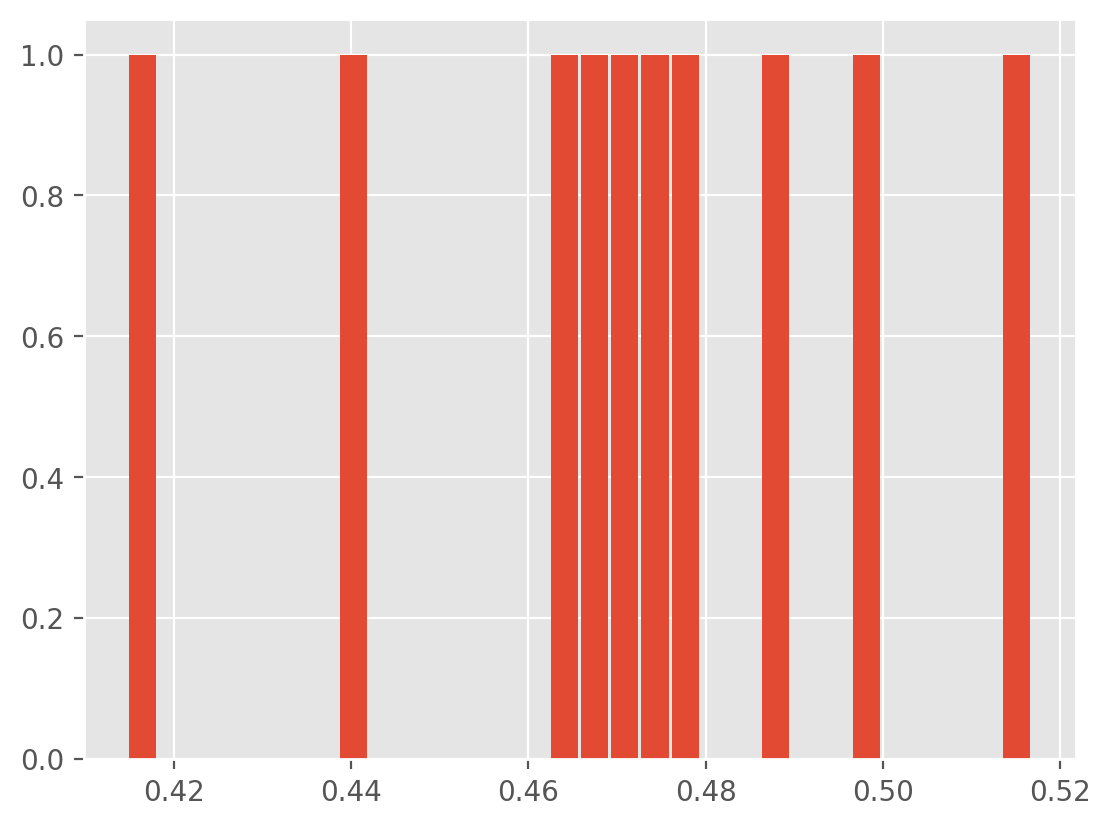

In [203]:
fig, ax = plt.subplots()

ax.hist(rmses_1078, bins=30, rwidth=0.9)


In [204]:
d_718, _ = get_all_drug_dfs("Drug_718", path=path, wanted_jobs=os.listdir(path))

In [205]:
rmses_718 = []
for d in d_718:
    print(d)
    print(d["AUC"])
    rmse_curr = mean_squared_error(d["AUC"], d["PredictedAUC"], squared=False)
    rmses_718.append(rmse_curr)
rmses_718

        AUC      Sample     Drug1  PredictedAUC  AUCError               Job
0    0.3349  ACH-000001  Drug_718        0.8591    0.5242  9010146.amn-0001
1    0.3056  ACH-000002  Drug_718        0.8566    0.5510  9010146.amn-0001
2    0.2965  ACH-000004  Drug_718        0.6921    0.3956  9010146.amn-0001
3    0.3751  ACH-000006  Drug_718        0.7567    0.3816  9010146.amn-0001
4    0.6034  ACH-000007  Drug_718        0.7602    0.1568  9010146.amn-0001
..      ...         ...       ...           ...       ...               ...
553  0.3533  ACH-001190  Drug_718        0.6879    0.3346  9010146.amn-0001
554  0.3575  ACH-001306  Drug_718        0.6148    0.2573  9010146.amn-0001
555  0.1977  ACH-001307  Drug_718        0.7586    0.5609  9010146.amn-0001
556  0.2123  ACH-001307  Drug_718        0.6351    0.4228  9010146.amn-0001
557  0.9664  ACH-001321  Drug_718        0.8499   -0.1165  9010146.amn-0001

[558 rows x 6 columns]
0      0.3349
1      0.3056
2      0.2965
3      0.3751
4      0

[0.3691187673724045,
 0.4413033379177498,
 0.3279272651892189,
 0.37985040886943844,
 0.4832248748166603,
 0.39510465799659883,
 0.36345639947454,
 0.4109842132375232,
 0.4551709743952262,
 0.42187087753461716]

(array([1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
        0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.]),
 array([0.32792727, 0.33310385, 0.33828044, 0.34345703, 0.34863361,
        0.3538102 , 0.35898679, 0.36416337, 0.36933996, 0.37451655,
        0.37969314, 0.38486972, 0.39004631, 0.3952229 , 0.40039948,
        0.40557607, 0.41075266, 0.41592924, 0.42110583, 0.42628242,
        0.431459  , 0.43663559, 0.44181218, 0.44698877, 0.45216535,
        0.45734194, 0.46251853, 0.46769511, 0.4728717 , 0.47804829,
        0.48322487]),
 <BarContainer object of 30 artists>)

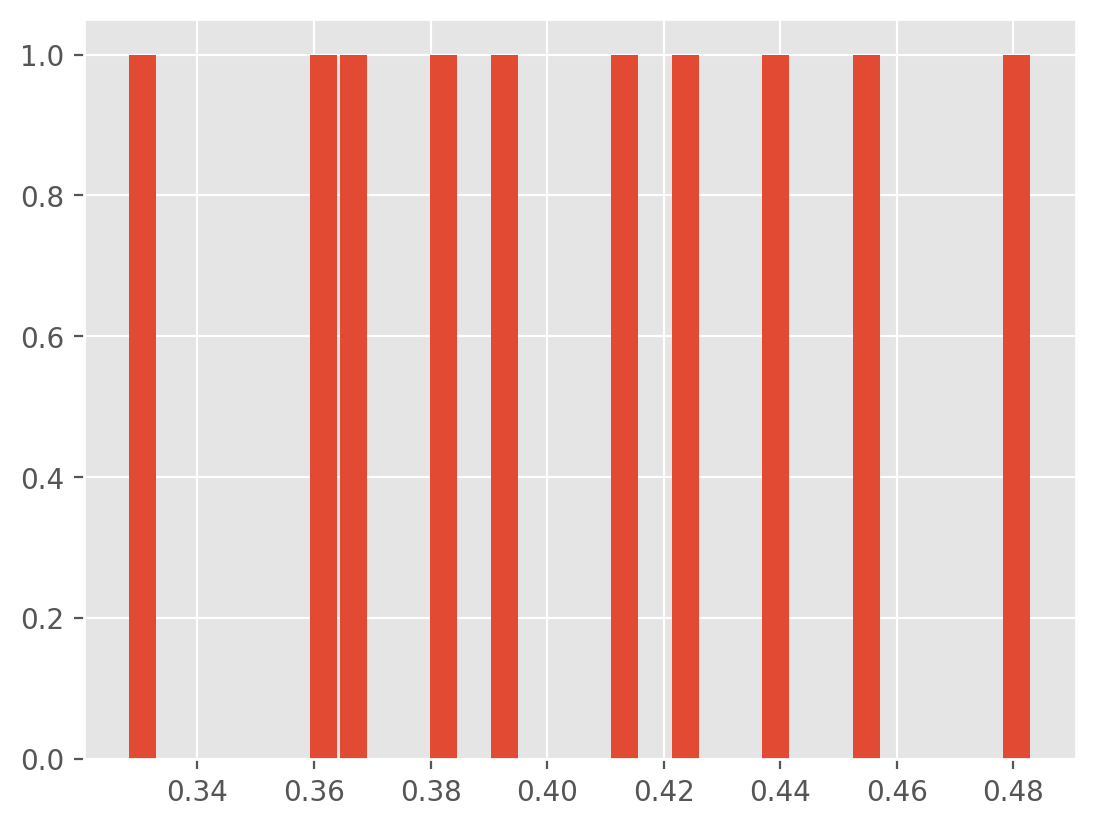

In [206]:
fig, ax = plt.subplots()

ax.hist(rmses_718, bins=30, rwidth=0.9)

In [207]:
d_984, _ = get_all_drug_dfs("Drug_984", path=path, wanted_jobs=os.listdir(path))

In [208]:
rmses_984 = []
for d in d_984:
    # print(d)
    # print(d["AUC"])
    rmse_curr = mean_squared_error(d["AUC"], d["PredictedAUC"], squared=False)
    rmses_984.append(rmse_curr)
rmses_984

[0.2295152020354381,
 0.23086406656176972,
 0.23713764373865673,
 0.23063011233516043,
 0.232643323541545,
 0.22344789967069253,
 0.2257117889883284,
 0.2250740921458242,
 0.22753147108013505,
 0.2295788194259312]

(array([1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.2234479 , 0.22390422, 0.22436055, 0.22481687, 0.2252732 ,
        0.22572952, 0.22618585, 0.22664217, 0.2270985 , 0.22755482,
        0.22801115, 0.22846747, 0.2289238 , 0.22938012, 0.22983645,
        0.23029277, 0.2307491 , 0.23120542, 0.23166175, 0.23211807,
        0.2325744 , 0.23303072, 0.23348705, 0.23394337, 0.23439969,
        0.23485602, 0.23531234, 0.23576867, 0.23622499, 0.23668132,
        0.23713764]),
 <BarContainer object of 30 artists>)

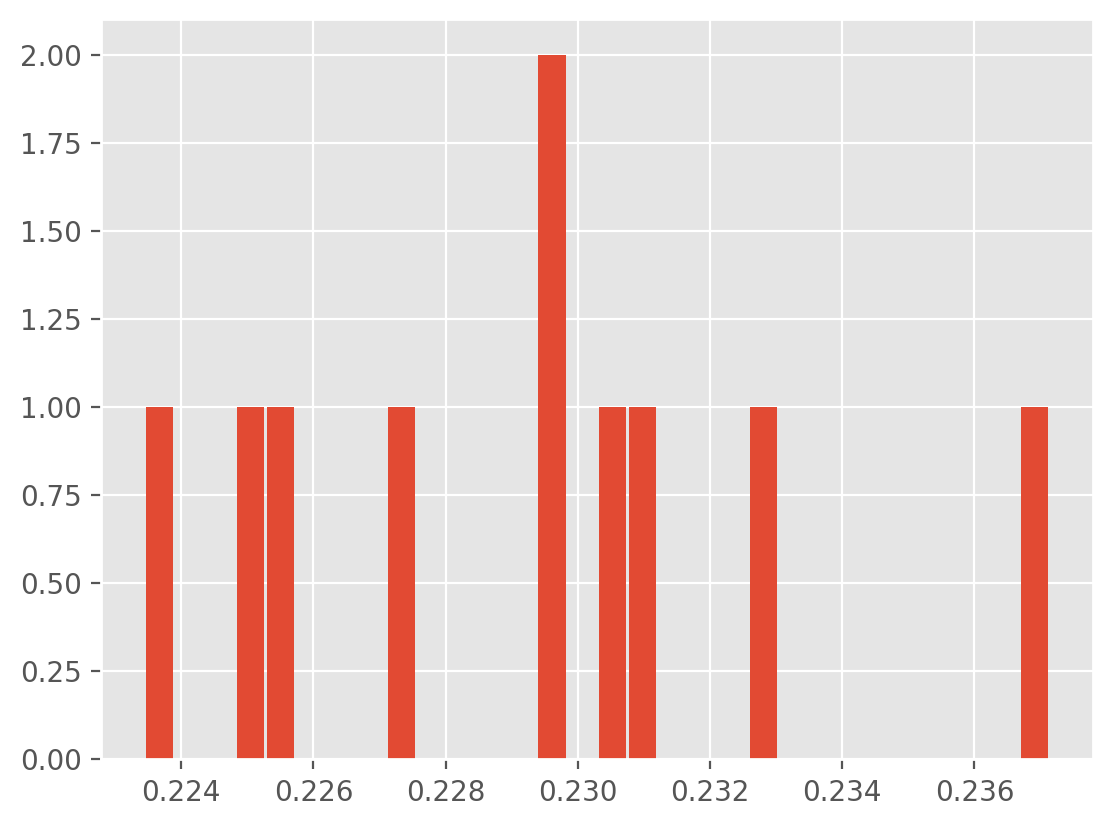

In [209]:
fig, ax = plt.subplots()

ax.hist(rmses_984, bins=30, rwidth=0.9)

In [262]:
np.log(big_df["AUC"])


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0      False
1      False
2      False
3      False
4      False
       ...  
721    False
722    False
723    False
724    False
725    False
Name: AUC, Length: 3436996, dtype: bool

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: supplied range of [-inf, 0.0] is not finite

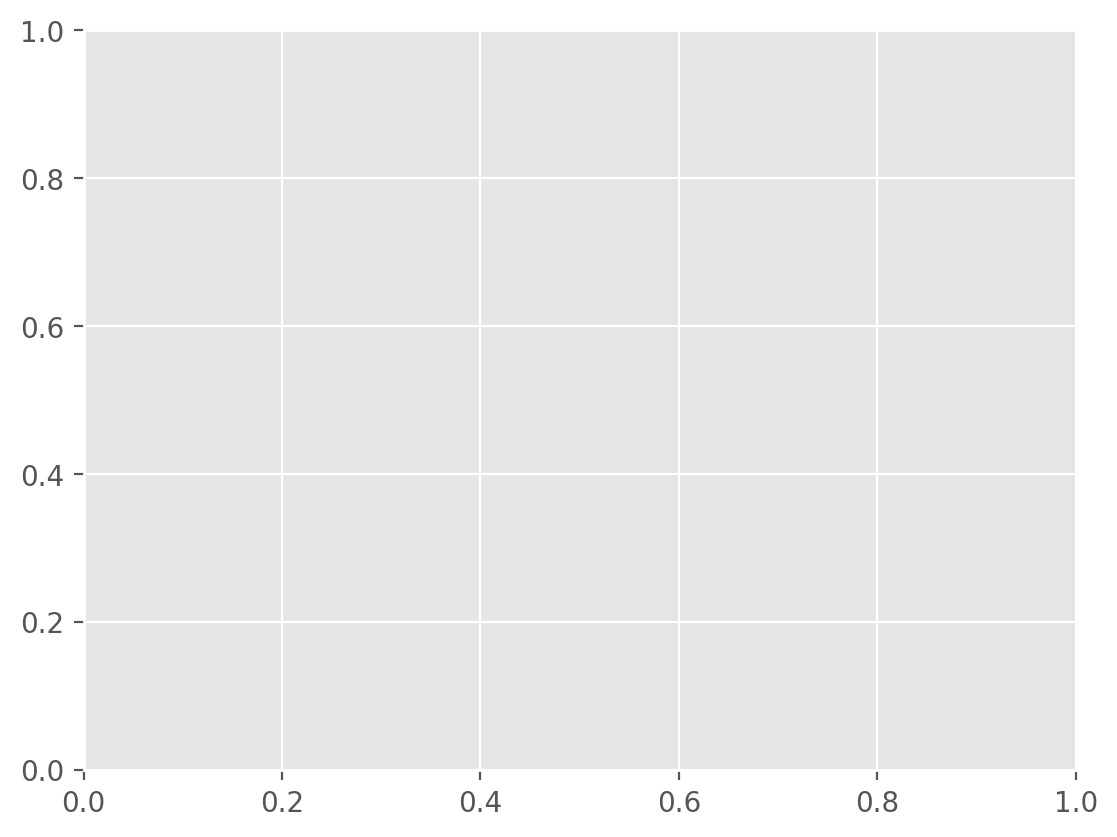

In [252]:
fig, ax = plt.subplots()
confint = st.t.interval(confidence = 0.95, 
                        df = len(big_df["AUC"])-1, 
                        loc = np.mean(big_df["AUC"]), 
                        scale = st.sem(big_df["AUC"]) )

heights, bins, patches = ax.hist(big_df["AUC"], bins=30, rwidth=0.9)
ax.vlines(x = np.mean(big_df["AUC"]), 
          ymin = 0, 
          ymax=max(heights), 
          colors="black", 
          linestyles="dashed")

ax.vlines(x = np.mean(big_df[big_df["Drug1"] == "Drug_1078"]["AUC"]), 
          ymin = 0, 
          ymax=max(heights), 
          colors="red", 
          linestyles="dashed")
# ax.text(x = np.mean(big_df[big_df["Drug1"] == "Drug_1078"]["AUC"]),
#         y=max(heights), 
#         s = "Drug_1078")


ax.vlines(x = np.mean(big_df[big_df["Drug1"] == "Drug_984"]["AUC"]), 
          ymin = 0, 
          ymax=max(heights), 
          colors="red", 
          linestyles="dashed")
# ax.text(x = np.mean(big_df[big_df["Drug1"] == "Drug_984"]["AUC"]),
#         y=max(heights), 
#         s = "Drug_1078")

ax.vlines(x = np.mean(big_df[big_df["Drug1"] == "Drug_736"]["AUC"]), 
          ymin = 0, 
          ymax=max(heights), 
          colors="red", 
          linestyles="dashed")
# ax.text(x = np.mean(big_df[big_df["Drug1"] == "Drug_736"]["AUC"]),
#         y=max(heights), 
#         s = "Drug_1078")

ax.vlines(x = np.mean(big_df[big_df["Drug1"] == "Drug_1079"]["AUC"]), 
          ymin = 0, 
          ymax=max(heights), 
          colors="red", 
          linestyles="dashed")
# ax.text(x = np.mean(big_df[big_df["Drug1"] == "Drug_1079"]["AUC"]),
#         y=max(heights), 
#         s = "Drug_1078")

ax.vlines(x = np.mean(big_df[big_df["Drug1"] == "Drug_1026"]["AUC"]), 
          ymin = 0, 
          ymax=max(heights), 
          colors="green", 
          linestyles="dashed")
# ax.text(x = np.mean(big_df[big_df["Drug1"] == "Drug_1079"]["AUC"]),
#         y=max(heights), 
#         s = "Drug_1078")

ax.vlines(x = np.mean(big_df[big_df["Drug1"] == "Drug_1026"]["AUC"]), 
          ymin = 0, 
          ymax=max(heights), 
          colors="green", 
          linestyles="dashed")
# ax.text(x = np.mean(big_df[big_df["Drug1"] == "Drug_1079"]["AUC"]),
#         y=max(heights), 
#         s = "Drug_1078")

ax.set_title("Total AUC Distribution with Means of Poor performing Drugs Overlayed")
